In [ ]:
import pandas as pd
import os, math, json
from scipy.stats import gaussian_kde
from tqdm import tqdm
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.utils import resample
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df ='/content/drive/MyDrive/math/ObesityDataSet_raw_and_data_sinthetic.csv'
CSV_PATH = pd.read_csv(df)

In [ ]:
# Recode target
obe = {
 'Insufficient_Weight': 'Insufficient Weight',
 'Normal_Weight': 'Normal Weight',
 'Overweight_Level_I': 'Overweight I',
 'Overweight_Level_II': 'Overweight II',
 'Obesity_Type_I': 'Obesity I',
 'Obesity_Type_II': 'Obesity II',
 'Obesity_Type_III': 'Obesity III'
}


CSV_PATH['NObeyesdad_new'] = CSV_PATH['NObeyesdad'].map(obe).astype('category')


# Identificar tipos (ejemplo, ajústalo con las columnas reales)
continuous = ['Age', 'Height', 'Weight', 'FCVC', 'NCP']  # EJEMPLO — revisa dataset
binary = ['FAVC','SMOKE']  # columnas binarias (sí/no)
categorical = ['Gender','CAEC','MTRANS']  # ejemplo

In [ ]:
CSV_PATH.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad', 'NObeyesdad_new'],
      dtype='object')

In [ ]:
continuous_features = ["Age",
                       "Height",
                       "Weight",
                       "NCP",
                       "FCVC",
                       "CH2O",
                       "FAF",
                       "TUE"]
binary_features = ["family_history_with_overweight",
                   "FAVC",
                   "SMOKE",
                   "SCC"]
categorical_features = ["Gender",
                        "CAEC",
                        "CALC",
                        "MTRANS",
                        "NObeyesdad_new"]

# PRIMER TASK

In [ ]:
import os, math, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tqdm import tqdm
np.random.seed(42)

# -------------------------
# User-specified lists (as provided)
# -------------------------
continuous_features = ["Age", "Height", "Weight", "NCP", "FCVC", "CH2O", "FAF","TUE"]
binary_features = ["family_history_with_overweight", "FAVC", "SMOKE", "SCC"]
categorical_features = ["Gender", "CAEC", "CALC", "MTRANS", "NObeyesdad"]

# -------------------------
# Parameters
# -------------------------
CSV_PATH = '/content/drive/MyDrive/math/ObesityDataSet_raw_and_data_sinthetic.csv'
OUT_DIR = "/content/drive/MyDrive/math"
BOOT_N_PROPORTION = 2000    # bootstrap iterations for proportions
BOOT_N_KDE = 500           # bootstrap iterations for KDE bands (pointwise)
KDE_GRID_N = 500

os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR,"figs"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR,"tables"), exist_ok=True)

# -------------------------
# Utility functions
# -------------------------
def bootstrap_ci_values(data, statfunc=np.mean, n_boot=1000, ci=95):
    data = np.array(data)
    n = len(data)
    boots = []
    for _ in range(n_boot):
        s = np.random.choice(data, size=n, replace=True)
        boots.append(statfunc(s))
    lo = np.percentile(boots, (100-ci)/2)
    hi = np.percentile(boots, 100-(100-ci)/2)
    return lo, hi, boots

def pmf_with_bootstrap(series, n_boot=1000):
    vals = series.dropna()
    counts = vals.value_counts().sort_index()
    pmf = (counts / counts.sum()).astype(float)
    rows = []
    for cat in pmf.index:
        binary = (vals == cat).astype(int).values
        lo, hi, _ = bootstrap_ci_values(binary, statfunc=np.mean, n_boot=n_boot)
        rows.append({"category": cat, "pmf": pmf[cat], "ci_low": lo, "ci_high": hi, "count": int(counts[cat])})
    df_pmf = pd.DataFrame(rows).sort_values("pmf", ascending=False)
    return df_pmf

def kde_pdf_cdf_with_boot(series, grid_n=500, boot_n=500):
    data = series.dropna().values
    if len(data) < 3:
        raise ValueError("Not enough data for KDE")
    grid = np.linspace(data.min(), data.max(), grid_n)
    kde = gaussian_kde(data)
    pdf = kde(grid)
    from numpy import trapz
    pdf = pdf / trapz(pdf, grid)
    cdf = np.cumsum(pdf)
    cdf = cdf / cdf[-1]
    # bootstrap
    pdf_boot = np.empty((boot_n, grid_n))
    cdf_boot = np.empty((boot_n, grid_n))
    for i in range(boot_n):
        samp = np.random.choice(data, size=len(data), replace=True)
        kv = gaussian_kde(samp)
        p = kv(grid)
        p = p / trapz(p, grid)
        pdf_boot[i,:] = p
        c = np.cumsum(p); c = c / c[-1]
        cdf_boot[i,:] = c
    pdf_low = np.percentile(pdf_boot, 2.5, axis=0)
    pdf_high = np.percentile(pdf_boot, 97.5, axis=0)
    cdf_low = np.percentile(cdf_boot, 2.5, axis=0)
    cdf_high = np.percentile(cdf_boot, 97.5, axis=0)
    return grid, pdf, pdf_low, pdf_high, cdf, cdf_low, cdf_high

def bootstrap_mean_var_ci(series, n_boot=2000):
    arr = np.array(series.dropna())
    lo_m, hi_m, _ = bootstrap_ci_values(arr, statfunc=np.mean, n_boot=n_boot)
    lo_v, hi_v, _ = bootstrap_ci_values(arr, statfunc=lambda x: x.var(ddof=1), n_boot=n_boot)
    return {"mean": arr.mean(), "mean_ci": (lo_m, hi_m), "var": arr.var(ddof=1), "var_ci": (lo_v, hi_v)}

def plot_pdf_cdf_combined(col, grid, pdf, pdf_low, pdf_high, cdf, cdf_low, cdf_high, out_dir):
    """
    Creates a combined PDF + CDF figure for continuous features.
    """
    fig, axs = plt.subplots(1, 2, figsize=(12,4))

    # ------ PDF ------
    axs[0].plot(grid, pdf, label="KDE PDF")
    axs[0].fill_between(grid, pdf_low, pdf_high, alpha=0.3, label="95% CI")
    axs[0].set_title(f"PDF (KDE) — {col}")
    axs[0].set_xlabel(col)
    axs[0].set_ylabel("Density")
    axs[0].legend()

    # ------ CDF ------
    axs[1].plot(grid, cdf, label="CDF")
    axs[1].fill_between(grid, cdf_low, cdf_high, alpha=0.3, label="95% CI")
    axs[1].set_title(f"CDF (KDE) — {col}")
    axs[1].set_xlabel(col)
    axs[1].set_ylabel("Cumulative Probability")
    axs[1].legend()

    plt.tight_layout()
    save_path = os.path.join(out_dir, "figs", f"pdf_cdf_{col}.png")
    plt.savefig(save_path, dpi=200)
    plt.close(fig)


# -------------------------
# Load dataset
# -------------------------
df = pd.read_csv(CSV_PATH)
n = len(df)

# Save an index of columns and types
pd.DataFrame({"column": df.columns, "dtype": df.dtypes.astype(str)}).to_csv(os.path.join(OUT_DIR,"columns_types.csv"), index=False)

# -------------------------
# Process binary features (PMF + CI)
# -------------------------
for col in binary_features:
    pmf_df = pmf_with_bootstrap(df[col], n_boot=BOOT_N_PROPORTION)
    pmf_csv = os.path.join(OUT_DIR,"tables", f"pmf_{col}.csv")
    pmf_df.to_csv(pmf_csv, index=False)
    # plot
    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(pmf_df['category'].astype(str), pmf_df['pmf'])
    ax.errorbar(pmf_df['category'].astype(str), pmf_df['pmf'],
                yerr=[pmf_df['pmf']-pmf_df['ci_low'], pmf_df['ci_high']-pmf_df['pmf']],
                fmt='none', ecolor='black', capsize=3)
    ax.set_title(f"PMF for {col}")
    ax.set_ylabel("Proportion")
    plt.xticks(rotation=45, ha='right')
    fig_path = os.path.join(OUT_DIR,"figs",f"pmf_{col}.png")
    plt.tight_layout()
    plt.savefig(fig_path, dpi=200)
    plt.close(fig)

# -------------------------
# Process categorical features (PMF + CI)
# -------------------------
for col in categorical_features:
    pmf_df = pmf_with_bootstrap(df[col], n_boot=BOOT_N_PROPORTION)
    pmf_csv = os.path.join(OUT_DIR,"tables", f"pmf_{col}.csv")
    pmf_df.to_csv(pmf_csv, index=False)
    # plot
    fig, ax = plt.subplots(figsize=(7,4))
    ax.bar(pmf_df['category'].astype(str), pmf_df['pmf'])
    ax.errorbar(pmf_df['category'].astype(str), pmf_df['pmf'],
                yerr=[pmf_df['pmf']-pmf_df['ci_low'], pmf_df['ci_high']-pmf_df['pmf']],
                fmt='none', ecolor='black', capsize=3)
    ax.set_title(f"PMF for {col}")
    ax.set_ylabel("Proportion")
    plt.xticks(rotation=45, ha='right')
    fig_path = os.path.join(OUT_DIR,"figs",f"pmf_{col}.png")
    plt.tight_layout()
    plt.savefig(fig_path, dpi=200)
    plt.close(fig)

# -------------------------
# Process continuous features (KDE PDF/CDF + mean/var CI)
# -------------------------
for col in continuous_features:
    # Descriptive
    stats = bootstrap_mean_var_ci(df[col], n_boot=BOOT_N_PROPORTION)
    stats_df = pd.DataFrame([{"stat":"mean","estimate":stats["mean"], "ci_lo":stats["mean_ci"][0], "ci_hi":stats["mean_ci"][1]},
                             {"stat":"var","estimate":stats["var"], "ci_lo":stats["var_ci"][0], "ci_hi":stats["var_ci"][1]}])
    stats_csv = os.path.join(OUT_DIR,"tables", f"desc_{col}.csv")
    stats_df.to_csv(stats_csv, index=False)

    # KDE
    try:
        grid, pdf, pdf_low, pdf_high, cdf, cdf_low, cdf_high = kde_pdf_cdf_with_boot(df[col], grid_n=KDE_GRID_N, boot_n=BOOT_N_KDE)
    except Exception as e:
        print(f"Skipping KDE for {col} due to error:", e)
        continue

    pdf_table = pd.DataFrame({"x":grid, "pdf":pdf, "pdf_low":pdf_low, "pdf_high":pdf_high, "cdf":cdf, "cdf_low":cdf_low, "cdf_high":cdf_high})
    pdf_csv = os.path.join(OUT_DIR,"tables", f"kde_{col}.csv")
    pdf_table.to_csv(pdf_csv, index=False)

    # Plot PDF
    fig, ax = plt.subplots(figsize=(7,4))
    ax.plot(grid, pdf, label="KDE PDF")
    ax.fill_between(grid, pdf_low, pdf_high, alpha=0.3, label="95% CI")
    ax.set_title(f"KDE PDF — {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Density")
    ax.legend()
    figpath1 = os.path.join(OUT_DIR,"figs", f"kde_pdf_{col}.png")
    plt.tight_layout()
    plt.savefig(figpath1, dpi=200)
    plt.close(fig)

    # Plot CDF
    fig, ax = plt.subplots(figsize=(7,4))
    ax.plot(grid, cdf, label="CDF (from KDE)")
    ax.fill_between(grid, cdf_low, cdf_high, alpha=0.25, label="95% CI")
    ax.set_title(f"CDF — {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Cumulative probability")
    ax.legend()
    figpath2 = os.path.join(OUT_DIR,"figs", f"kde_cdf_{col}.png")
    plt.tight_layout()
    plt.savefig(figpath2, dpi=200)
    plt.close(fig)

# -------------------------
# Create a master markdown (simple)
# -------------------------
md_lines = []
md_lines.append("# Task 1 — Marginal Distributions")
md_lines.append(f"Dataset: {os.path.basename(CSV_PATH)}  \nInstances: {n}\n")
md_lines.append("## Discrete / Categorical variables (PMFs saved to tables/ and plots to figs/)\n")
for col in binary_features + categorical_features:
    pmf_csv = os.path.join("tables", f"pmf_{col}.csv")
    img = os.path.join("figs", f"pmf_{col}.png")
    md_lines.append(f"### {col}\nSupport: {sorted(df[col].dropna().unique().tolist(), key=lambda x:str(x))}\n")
    md_lines.append(f"PMF table: `{pmf_csv}`  \nFigure: `{img}`\n")
md_lines.append("\n## Continuous variables (KDE + mean/var bootstraps)\n")
for col in continuous_features:
    desc = os.path.join("tables", f"desc_{col}.csv")
    kpdf = os.path.join("tables", f"kde_{col}.csv")
    img1 = os.path.join("figs", f"kde_pdf_{col}.png")
    img2 = os.path.join("figs", f"kde_cdf_{col}.png")
    md_lines.append(f"### {col}\nSupport: [{df[col].min()}, {df[col].max()}]  \nDesc table: `{desc}`  \nKDE table: `{kpdf}`  \nFigures: `{img1}`, `{img2}`\n")
md_path = os.path.join(OUT_DIR, "task1_report.md")
with open(md_path, "w") as f:
    f.write("\n".join(md_lines))

print("Task 1 outputs saved to", OUT_DIR)
print("Open", md_path, "for a skeleton report (tables and figures saved in tables/ and figs/).")


# ----------------------------------------------------
# Create unified table: Feature / Type / Value / PMF / CDF
# ----------------------------------------------------
master_rows = []

# ---- Binary & Categorical (exact PMF) ----
for col in binary_features + categorical_features:
    pmf_df = pd.read_csv(os.path.join(OUT_DIR, "tables", f"pmf_{col}.csv"))
    for _, row in pmf_df.iterrows():
        master_rows.append({
            "Feature": col,
            "Type": "binary" if col in binary_features else "categorical",
            "Value": row["category"],
            "PMF": row["pmf"],
            "CDF": pmf_df["pmf"].loc[:_].sum()  # cumulative
        })

# ---- Continuous (KDE PDF & CDF using kde_*.csv) ----
for col in continuous_features:
    kde_path = os.path.join(OUT_DIR, "tables", f"kde_{col}.csv")

    # Skip features where KDE failed
    if not os.path.exists(kde_path):
        continue

    kde_df = pd.read_csv(kde_path)

    for _, row in kde_df.iterrows():
        master_rows.append({
            "Feature": col,
            "Type": "continuous",
            "Value": row["x"],
            "PMF": row["pdf"],   # PDF used instead of PMF
            "CDF": row["cdf"]
        })

# Convert to dataframe
master_table = pd.DataFrame(master_rows)

# Save
master_csv_path = os.path.join(OUT_DIR, "tables", "task1_master_distribution_table.csv")
master_table.to_csv(master_csv_path, index=False)

print("Unified master distribution table saved to:", master_csv_path)


/tmp/ipython-input-2773068697.py:63: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pdf = pdf / trapz(pdf, grid)
/tmp/ipython-input-2773068697.py:73: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p = p / trapz(p, grid)


Task 1 outputs saved to /content/drive/MyDrive/math
Open /content/drive/MyDrive/math/task1_report.md for a skeleton report (tables and figures saved in tables/ and figs/).
Unified master distribution table saved to: /content/drive/MyDrive/math/tables/task1_master_distribution_table.csv


# TAREA 2

In [ ]:

import os, itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests

np.random.seed(42)

# -----------------------
# USER PARAMETERS - edit if necessary
# -----------------------
OUT_DIR = "/content/drive/MyDrive/math"
continuous_features = ["Age", "Height", "Weight", "NCP", "FCVC", "CH2O", "FAF","TUE"]

# mapping: original 7-class to 4-class required by the assignment
map4 = {
 'Insufficient_Weight': 'Insufficient Weight',
 'Normal_Weight': 'Normal Weight',
 'Overweight_Level_I': 'Overweight',
 'Overweight_Level_II': 'Overweight',
 'Obesity_Type_I': 'Obesity',
 'Obesity_Type_II': 'Obesity',
 'Obesity_Type_III': 'Obesity'
}

target_orig = "NObeyesdad"
target_new = "NObeyesdad_new"

BOOT_N = 2000   # bootstrap iterations for mean/variance CIs
ALPHA = 0.05

os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR,"figs2"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR,"tables2"), exist_ok=True)

# -----------------------
# Utilities
# -----------------------
def bootstrap_ci(data, statfunc, n_boot=2000, ci=95):
    """Return (est, lo, hi, boot_samples) for statistic statfunc."""
    data = np.array(data.dropna())
    if len(data) == 0:
        return np.nan, np.nan, np.nan, []
    boots = []
    n = len(data)
    for _ in range(n_boot):
        s = np.random.choice(data, size=n, replace=True)
        boots.append(statfunc(s))
    boots = np.array(boots)
    lo = np.percentile(boots, (100-ci)/2)
    hi = np.percentile(boots, 100-(100-ci)/2)
    est = statfunc(data)
    return est, lo, hi, boots

def welch_ttest(group1, group2):
    """Return t_stat, df_welch, p_two_sided for two arrays (drops na)."""
    x1 = np.array(group1.dropna())
    x2 = np.array(group2.dropna())
    n1 = len(x1); n2 = len(x2)
    if n1 < 2 or n2 < 2:
        return np.nan, np.nan, np.nan
    m1 = x1.mean(); m2 = x2.mean()
    s1 = x1.var(ddof=1); s2 = x2.var(ddof=1)
    se = np.sqrt(s1/n1 + s2/n2)
    t = (m1 - m2) / se
    # Welch-Satterthwaite df
    num = (s1/n1 + s2/n2)**2
    den = ( (s1**2) / ( (n1**2) * (n1 - 1) ) ) + ( (s2**2) / ( (n2**2) * (n2 - 1) ) )
    df = num / den if den != 0 else np.nan
    p = stats.t.sf(np.abs(t), df)*2
    return t, df, p

# -----------------------
# Load and prepare data
# -----------------------
df = pd.read_csv(CSV_PATH)
# create recoded 4-class target
if target_orig not in df.columns:
    raise ValueError(f"{target_orig} column not found in dataset")
df[target_new] = df[target_orig].map(map4).astype('category')

# check classes
classes = df[target_new].cat.categories.tolist()
print("Target new classes:", classes)

# -----------------------
# Output containers
# -----------------------
summary_rows = []
anova_rows = []
pairwise_rows = []
tukey_summaries = {}

# -----------------------
# For each continuous feature
# -----------------------
for col in continuous_features:
    print("\n\n====== Feature:", col, "======")
    out_prefix = os.path.join(OUT_DIR, "tables2", col)
    # 1) Conditional sample means and variances (per class)
    groups = df.groupby(target_new)[col]
    group_stats = []
    for lvl, series in groups:
        n = series.dropna().shape[0]
        mean, mean_lo, mean_hi, mean_boots = bootstrap_ci(series, np.mean, n_boot=BOOT_N, ci=95)
        var, var_lo, var_hi, var_boots = bootstrap_ci(series, lambda x: x.var(ddof=1), n_boot=BOOT_N, ci=95)
        group_stats.append({
            "feature": col,
            "level": lvl,
            "n": int(n),
            "mean": float(mean) if not np.isnan(mean) else np.nan,
            "var": float(var) if not np.isnan(var) else np.nan
        })
    gs_df = pd.DataFrame(group_stats)
    gs_csv = f"{out_prefix}_group_stats.csv"
    gs_df.to_csv(gs_csv, index=False)
    print("Saved group stats:", gs_csv)

    # Append to summary table
    for r in group_stats:
        summary_rows.append(r)

    # 2) One-way ANOVA using OLS
    # formula: feature ~ C(target_new)
    formula = f"{col} ~ C({target_new})"
    # remove rows with NA in either col or target
    anova_df = df[[col, target_new]].dropna()
    if anova_df.shape[0] < 2:
        print("Not enough data for ANOVA for", col)
        anova_rows.append({"feature":col, "F":np.nan, "p":np.nan, "df_between":np.nan, "df_within":np.nan})
        continue

    model = smf.ols(formula, data=anova_df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)  # type II
    # extract F and p
    try:
        F = float(anova_table.loc[f"C({target_new})", "F"])
        p = float(anova_table.loc[f"C({target_new})", "PR(>F)"])
        df_between = int(anova_table.loc[f"C({target_new})", "df"])
        df_within = int(anova_table.loc["Residual", "df"])
    except Exception as e:
        F = np.nan; p = np.nan; df_between = np.nan; df_within = np.nan
    print("ANOVA result: F = {:.4f}, df_between = {}, df_within = {}, p = {:.4g}".format(F, df_between, df_within, p))
    anova_rows.append({"feature":col, "F":F, "p":p, "df_between":df_between, "df_within":df_within})

    # 3) If ANOVA significant, run pairwise comparisons (Welch t-tests) and apply FDR
    pairwise_results = []
    if (not np.isnan(p)) and (p < ALPHA):
        levels = anova_df[target_new].unique().tolist()
        # ensure deterministic order
        levels = sorted(levels, key=lambda x: str(x))
        pairs = []
        for a,b in itertools.combinations(levels, 2):
            s1 = anova_df.loc[anova_df[target_new]==a, col].dropna()
            s2 = anova_df.loc[anova_df[target_new]==b, col].dropna()
            tstat, df_welch, pval = welch_ttest(s1, s2)
            pairs.append({"feature":col, "group1":a, "group2":b,
                          "t": float(tstat) if not np.isnan(tstat) else np.nan,
                          "df_welch": float(df_welch) if not np.isnan(df_welch) else np.nan,
                          "p_uncorrected": float(pval) if not np.isnan(pval) else np.nan})
        # apply FDR-BH correction to p-values
        pvals = [pp["p_uncorrected"] for pp in pairs]
        reject, pvals_adj, _, _ = multipletests(pvals, alpha=ALPHA, method='fdr_bh')
        for i, pp in enumerate(pairs):
            pp["p_adj_fdr_bh"] = float(pvals_adj[i])
            pp["reject_fdr"] = bool(reject[i])
            pairwise_results.append(pp)
        # save pairwise
        pairs_df = pd.DataFrame(pairwise_results)
        pairs_csv = f"{out_prefix}_pairwise_welch_fdr.csv"
        pairs_df.to_csv(pairs_csv, index=False)
        print("Pairwise Welch tests (with FDR) saved to:", pairs_csv)
    else:
        print("ANOVA not significant (p >= {}) — skipping pairwise tests for {}".format(ALPHA, col))

    for r in pairwise_results:
        pairwise_rows.append(r)

    # 4) (Optional) Tukey HSD post-hoc (for reference) - works on balanced or unbalanced ANOVA
    try:
        tukey = pairwise_tukeyhsd(endog=anova_df[col], groups=anova_df[target_new], alpha=ALPHA)
        tukey_summary = tukey.summary()
        # convert to dataframe
        tukey_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
        tukey_csv = f"{out_prefix}_tukey.csv"
        tukey_df.to_csv(tukey_csv, index=False)
        tukey_summaries[col] = tukey_df
        print("Tukey HSD saved to:", tukey_csv)
    except Exception as e:
        print("Tukey HSD failed for", col, e)


# -----------------------
# Save aggregated tables
# -----------------------
pd.DataFrame(summary_rows).to_csv(os.path.join(OUT_DIR,"tables2","continuous_group_stats_all.csv"), index=False)
pd.DataFrame(anova_rows).to_csv(os.path.join(OUT_DIR,"tables2","anova_results.csv"), index=False)
pd.DataFrame(pairwise_rows).to_csv(os.path.join(OUT_DIR,"tables2","pairwise_welch_fdr_all.csv"), index=False)

print("\nDONE: Task 2 results saved in", OUT_DIR)
print("Files:")
print("- continuous_group_stats_all.csv  (group means/vars + 95% CI)")
print("- anova_results.csv")
print("- pairwise_welch_fdr_all.csv  (pairwise t-tests with FDR-adjusted p-values, for features with significant ANOVA)")
print("- tukey CSVs (per-feature) if successful")


Target new classes: ['Insufficient Weight', 'Normal Weight', 'Obesity', 'Overweight']


====== Feature: Age ======


/tmp/ipython-input-607013196.py:108: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby(target_new)[col]


Saved group stats: /content/drive/MyDrive/math/tables2/Age_group_stats.csv
ANOVA result: F = 94.8926, df_between = 3, df_within = 2107, p = 1.32e-57
Pairwise Welch tests (with FDR) saved to: /content/drive/MyDrive/math/tables2/Age_pairwise_welch_fdr.csv
Tukey HSD saved to: /content/drive/MyDrive/math/tables2/Age_tukey.csv


====== Feature: Height ======


/tmp/ipython-input-607013196.py:108: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby(target_new)[col]


Saved group stats: /content/drive/MyDrive/math/tables2/Height_group_stats.csv
ANOVA result: F = 16.3647, df_between = 3, df_within = 2107, p = 1.632e-10
Pairwise Welch tests (with FDR) saved to: /content/drive/MyDrive/math/tables2/Height_pairwise_welch_fdr.csv
Tukey HSD saved to: /content/drive/MyDrive/math/tables2/Height_tukey.csv


====== Feature: Weight ======


/tmp/ipython-input-607013196.py:108: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby(target_new)[col]


Saved group stats: /content/drive/MyDrive/math/tables2/Weight_group_stats.csv
ANOVA result: F = 1992.5183, df_between = 3, df_within = 2107, p = 0
Pairwise Welch tests (with FDR) saved to: /content/drive/MyDrive/math/tables2/Weight_pairwise_welch_fdr.csv
Tukey HSD saved to: /content/drive/MyDrive/math/tables2/Weight_tukey.csv


====== Feature: NCP ======


/tmp/ipython-input-607013196.py:108: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby(target_new)[col]


Saved group stats: /content/drive/MyDrive/math/tables2/NCP_group_stats.csv
ANOVA result: F = 20.3693, df_between = 3, df_within = 2107, p = 5.191e-13
Pairwise Welch tests (with FDR) saved to: /content/drive/MyDrive/math/tables2/NCP_pairwise_welch_fdr.csv
Tukey HSD saved to: /content/drive/MyDrive/math/tables2/NCP_tukey.csv


====== Feature: FCVC ======


/tmp/ipython-input-607013196.py:108: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby(target_new)[col]


Saved group stats: /content/drive/MyDrive/math/tables2/FCVC_group_stats.csv
ANOVA result: F = 33.2694, df_between = 3, df_within = 2107, p = 5.254e-21
Pairwise Welch tests (with FDR) saved to: /content/drive/MyDrive/math/tables2/FCVC_pairwise_welch_fdr.csv
Tukey HSD saved to: /content/drive/MyDrive/math/tables2/FCVC_tukey.csv


====== Feature: CH2O ======


/tmp/ipython-input-607013196.py:108: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby(target_new)[col]


Saved group stats: /content/drive/MyDrive/math/tables2/CH2O_group_stats.csv
ANOVA result: F = 15.3559, df_between = 3, df_within = 2107, p = 6.959e-10
Pairwise Welch tests (with FDR) saved to: /content/drive/MyDrive/math/tables2/CH2O_pairwise_welch_fdr.csv
Tukey HSD saved to: /content/drive/MyDrive/math/tables2/CH2O_tukey.csv


====== Feature: FAF ======


/tmp/ipython-input-607013196.py:108: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby(target_new)[col]


Saved group stats: /content/drive/MyDrive/math/tables2/FAF_group_stats.csv
ANOVA result: F = 23.5881, df_between = 3, df_within = 2107, p = 5.152e-15
Pairwise Welch tests (with FDR) saved to: /content/drive/MyDrive/math/tables2/FAF_pairwise_welch_fdr.csv
Tukey HSD saved to: /content/drive/MyDrive/math/tables2/FAF_tukey.csv


====== Feature: TUE ======


/tmp/ipython-input-607013196.py:108: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby(target_new)[col]


Saved group stats: /content/drive/MyDrive/math/tables2/TUE_group_stats.csv
ANOVA result: F = 10.9011, df_between = 3, df_within = 2107, p = 4.187e-07
Pairwise Welch tests (with FDR) saved to: /content/drive/MyDrive/math/tables2/TUE_pairwise_welch_fdr.csv
Tukey HSD saved to: /content/drive/MyDrive/math/tables2/TUE_tukey.csv

DONE: Task 2 results saved in /content/drive/MyDrive/math
Files:
- continuous_group_stats_all.csv  (group means/vars + 95% CI)
- anova_results.csv
- pairwise_welch_fdr_all.csv  (pairwise t-tests with FDR-adjusted p-values, for features with significant ANOVA)
- tukey CSVs (per-feature) if successful


Features: 100%|██████████| 8/8 [00:10<00:00,  1.32s/it]
/tmp/ipython-input-3789743826.py:237: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "levene_W": float(levene_df_out[levene_df_out["feature"]==feat]["W"]) if feat in list(levene_df_out["feature"]) else np.nan,
/tmp/ipython-input-3789743826.py:238: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "levene_p": float(levene_df_out[levene_df_out["feature"]==feat]["p"]) if feat in list(levene_df_out["feature"]) else np.nan,
/tmp/ipython-input-3789743826.py:237: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "levene_W": float(levene_df_out[levene_df_out["feature"]==feat]["W"]) if feat in list(levene_df_out["feature"]) else np.nan,
/tmp/ipython-input-3

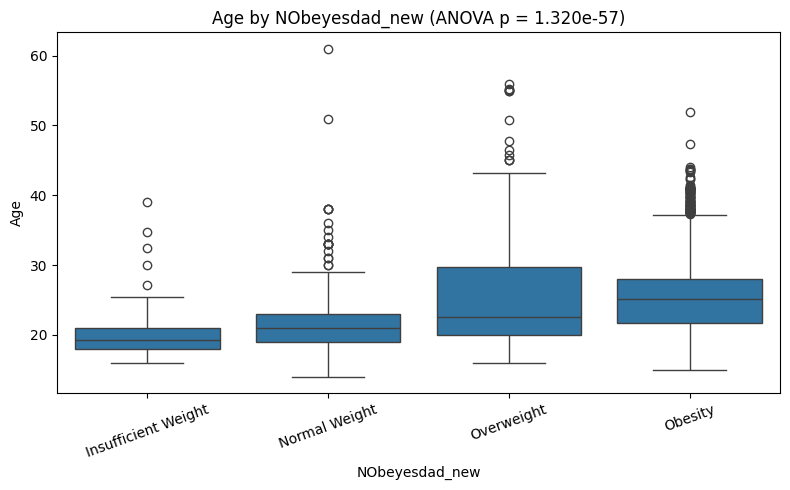

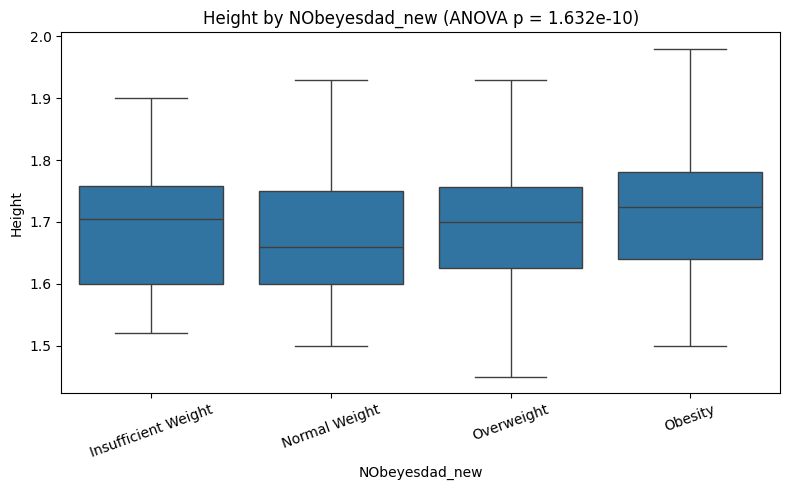

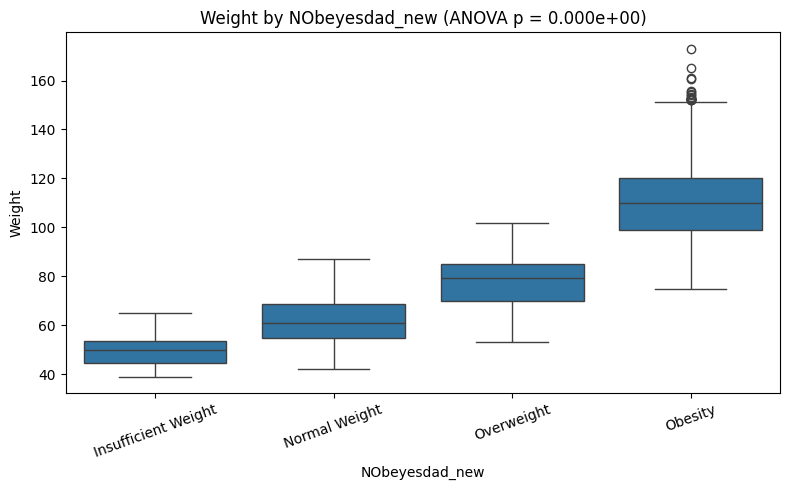

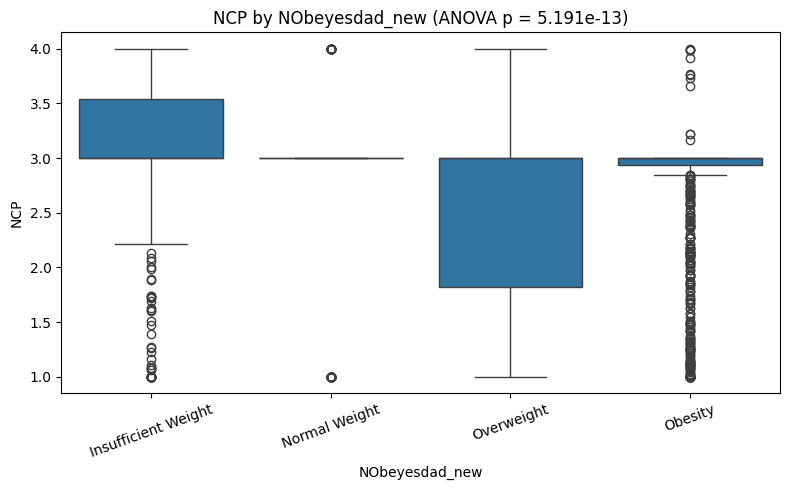

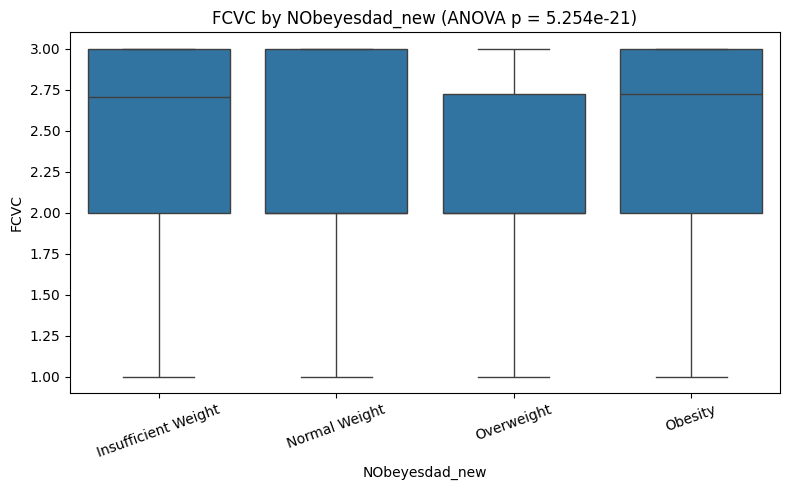

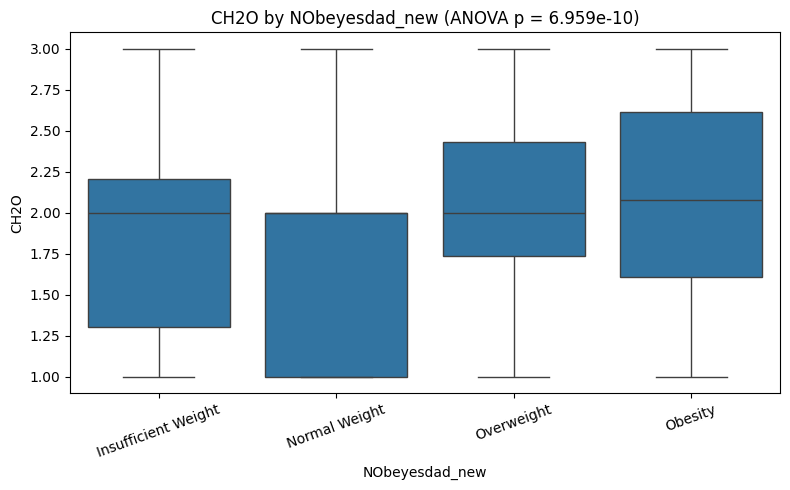

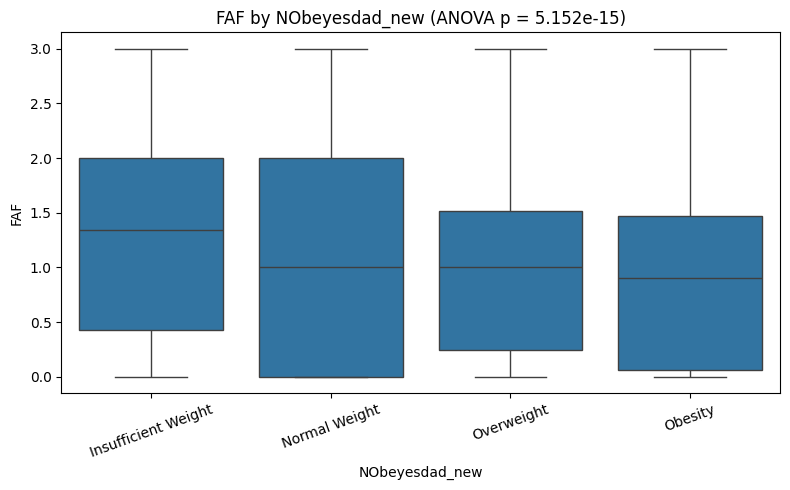

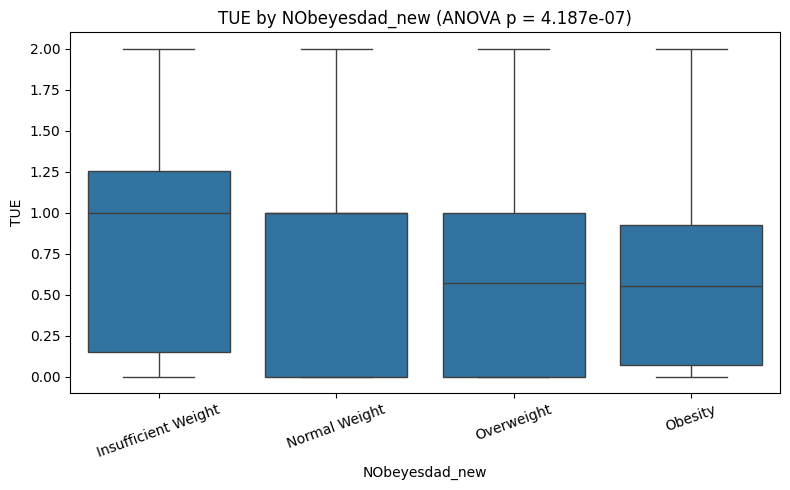

In [ ]:
import os, itertools, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests

np.random.seed(42)

# -----------------------
# USER PARAMETERS - edit if necessary
# -----------------------
CSV_PATH = "/content/drive/MyDrive/math/ObesityDataSet_raw_and_data_sinthetic.csv"  # <- update if needed
OUT_DIR = "/content/task2_outputs"
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR,"figs2"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR,"tables2"), exist_ok=True)

# Continuous features as you defined
continuous_features = ["Age", "Height", "Weight", "NCP", "FCVC", "CH2O", "FAF","TUE"]

# Mapping original 7 classes to 4 required categories
map4 = {
 'Insufficient_Weight': 'Insufficient Weight',
 'Normal_Weight': 'Normal Weight',
 'Overweight_Level_I': 'Overweight',
 'Overweight_Level_II': 'Overweight',
 'Obesity_Type_I': 'Obesity',
 'Obesity_Type_II': 'Obesity',
 'Obesity_Type_III': 'Obesity'
}
target_orig = "NObeyesdad"
target_new = "NObeyesdad_new"

# Algorithmic parameters
BOOT_MEAN_VAR = 2000   # bootstrap iterations for mean/variance CI (reduce to 1000 for speed)
ALPHA = 0.05

# -----------------------
# Utility functions
# -----------------------
def bootstrap_ci(data, statfunc, n_boot=1000, ci=95):
    """Bootstrap CI for a statistic statfunc (data: 1D array or Series). Returns (est, lo, hi, boots)."""
    arr = np.array(data.dropna()) if hasattr(data, "dropna") else np.array(data)
    if len(arr) == 0:
        return np.nan, np.nan, np.nan, np.array([])
    boots = []
    n = len(arr)
    for _ in range(n_boot):
        s = np.random.choice(arr, size=n, replace=True)
        boots.append(float(statfunc(s)))
    boots = np.array(boots)
    est = float(statfunc(arr))
    lo = float(np.percentile(boots, (100-ci)/2))
    hi = float(np.percentile(boots, 100-(100-ci)/2))
    return est, lo, hi, boots

def welch_ttest(x, y):
    """Welch t-test with Welch-Satterthwaite df. Returns t, df, p."""
    x = np.array(x.dropna()) if hasattr(x, "dropna") else np.array(x)
    y = np.array(y.dropna()) if hasattr(y, "dropna") else np.array(y)
    n1 = len(x); n2 = len(y)
    if n1 < 2 or n2 < 2:
        return np.nan, np.nan, np.nan
    m1, m2 = x.mean(), y.mean()
    s1, s2 = x.var(ddof=1), y.var(ddof=1)
    se = math.sqrt(s1/n1 + s2/n2)
    t = (m1 - m2) / se if se>0 else np.nan
    # Welch-Satterthwaite df
    num = (s1/n1 + s2/n2)**2
    den = 0
    if n1 > 1:
        den += (s1**2) / ((n1**2)*(n1-1))
    if n2 > 1:
        den += (s2**2) / ((n2**2)*(n2-1))
    df = num / den if den != 0 else np.nan
    p = stats.t.sf(abs(t), df)*2 if not np.isnan(t) and not np.isnan(df) else np.nan
    return float(t) if not np.isnan(t) else np.nan, float(df) if not np.isnan(df) else np.nan, float(p) if not np.isnan(p) else np.nan

# -----------------------
# Load & prepare data
# -----------------------
df = pd.read_csv(CSV_PATH)
n_total = len(df)

# Recode target into 4-levels
if target_orig not in df.columns:
    raise ValueError(f"{target_orig} not found in data columns")
df[target_new] = df[target_orig].map(map4)
df[target_new] = df[target_new].astype("category")
levels_order = ['Insufficient Weight','Normal Weight','Overweight','Obesity']
# ensure categories include all mapped labels
df[target_new] = df[target_new].cat.set_categories(levels_order, ordered=True)

# -----------------------
# Containers for output
# -----------------------
group_stats_rows = []   # per-feature per-level mean/var/CIs
anova_rows = []         # anova result per feature
levene_rows = []        # Levene's test results
pairwise_rows = []      # pairwise Welch results with FDR
tukey_rows = []         # tukey table aggregated

# -----------------------
# Main loop: continuous features
# -----------------------
for feat in tqdm(continuous_features, desc="Features"):
    # compute per-level descriptive with bootstrap CIs
    for lvl in levels_order:
        subset = df.loc[df[target_new]==lvl, feat].dropna()
        n = len(subset)
        mean, mean_lo, mean_hi, mean_boots = bootstrap_ci(subset, np.mean, n_boot=BOOT_MEAN_VAR, ci=95)
        var, var_lo, var_hi, var_boots = bootstrap_ci(subset, lambda x: x.var(ddof=1), n_boot=BOOT_MEAN_VAR, ci=95)
        group_stats_rows.append({
            "feature": feat,
            "level": lvl,
            "n": int(n),
            "mean": mean,
            "mean_lo": mean_lo,
            "mean_hi": mean_hi,
            "var": var,
            "var_lo": var_lo,
            "var_hi": var_hi
        })

    # ANOVA (one-way, type II via OLS)
    anova_df = df[[feat, target_new]].dropna()
    if anova_df.shape[0] < 3:
        anova_rows.append({"feature": feat, "F": np.nan, "p": np.nan, "df_between": np.nan, "df_within": np.nan})
        levene_rows.append({"feature":feat, "W":np.nan, "p":np.nan})
        continue

    # Levene's test (homogeneity of variances) — use center=median for robustness
    groups_list = [anova_df.loc[anova_df[target_new]==lvl, feat].dropna().values for lvl in levels_order]
    # remove empty groups for levene
    groups_for_levene = [g for g in groups_list if len(g)>0]
    if len(groups_for_levene) >= 2:
        W, p_levene = stats.levene(*groups_for_levene, center='median')
    else:
        W, p_levene = np.nan, np.nan
    levene_rows.append({"feature":feat, "W":float(W) if not np.isnan(W) else np.nan, "p":float(p_levene) if not np.isnan(p_levene) else np.nan})

    # Fit OLS and ANOVA table
    try:
        model = smf.ols(f"{feat} ~ C({target_new})", data=anova_df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        F = float(anova_table.loc[f"C({target_new})", "F"])
        pval = float(anova_table.loc[f"C({target_new})", "PR(>F)"])
        df_between = float(anova_table.loc[f"C({target_new})", "df"])
        df_within = float(anova_table.loc["Residual", "df"])
    except Exception as e:
        F, pval, df_between, df_within = np.nan, np.nan, np.nan, np.nan

    anova_rows.append({"feature": feat, "F": F, "p": pval, "df_between": df_between, "df_within": df_within})

    # If ANOVA significant -> post-hoc pairwise Welch t-tests and Tukey HSD
    if not np.isnan(pval) and pval < ALPHA:
        # pairwise Welch for all combinations
        level_present = [lvl for lvl in levels_order if anova_df.loc[anova_df[target_new]==lvl, feat].dropna().shape[0] >= 2]
        pairs = list(itertools.combinations(level_present, 2))
        pvals_raw = []
        tmp_rows = []
        for (a,b) in pairs:
            x = anova_df.loc[anova_df[target_new]==a, feat].dropna()
            y = anova_df.loc[anova_df[target_new]==b, feat].dropna()
            tstat, df_welch, pval_pair = welch_ttest(x,y)
            tmp_rows.append({"feature":feat, "group1":a, "group2":b, "t":tstat, "df_welch":df_welch, "p_uncorrected":pval_pair})
            pvals_raw.append(pval_pair if not np.isnan(pval_pair) else 1.0)
        # FDR correction over these pairs
        if len(pvals_raw) > 0:
            reject, pvals_fdr, _, _ = multipletests(pvals_raw, alpha=ALPHA, method='fdr_bh')
            for i, row in enumerate(tmp_rows):
                row["p_fdr"] = float(pvals_fdr[i])
                row["reject_fdr"] = bool(reject[i])
                pairwise_rows.append(row)
        # Tukey HSD
        try:
            tuk = pairwise_tukeyhsd(endog=anova_df[feat], groups=anova_df[target_new], alpha=ALPHA)
            tuk_df = pd.DataFrame(data=tuk._results_table.data[1:], columns=tuk._results_table.data[0])
            tuk_df["feature"] = feat
            tuk_df_path = os.path.join(OUT_DIR, "tables2", f"tukey_{feat}.csv")
            tuk_df.to_csv(tuk_df_path, index=False)
            # aggregate
            for _, r in tuk_df.iterrows():
                tukey_rows.append({"feature":feat, "group1":r["group1"], "group2":r["group2"], "meandiff":r["meandiff"], "p_adj":r["p-adj"], "lower":r["lower"], "upper":r["upper"], "reject":r["reject"]})
        except Exception as e:
            # tukey may fail if groups not balanced or insufficient
            pass

    # Save boxplot with ANOVA p annotated
    try:
        plt.figure(figsize=(8,5))
        sns.boxplot(x=target_new, y=feat, data=anova_df, order=[lvl for lvl in levels_order if lvl in anova_df[target_new].unique()])
        plt.title(f"{feat} by {target_new} (ANOVA p = {pval:.3e})")
        plt.xticks(rotation=20)
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR,"figs", f"box_{feat}.png"), dpi=200)
        plt.close()
    except Exception as e:
        pass

# -----------------------
# Save aggregated tables
# -----------------------
group_stats_df = pd.DataFrame(group_stats_rows)
anova_df_out = pd.DataFrame(anova_rows)
levene_df_out = pd.DataFrame(levene_rows)
pairwise_df = pd.DataFrame(pairwise_rows)
tukey_df_all = pd.DataFrame(tukey_rows)

group_stats_df.to_csv(os.path.join(OUT_DIR,"tables2","task2_group_stats_by_level.csv"), index=False)
anova_df_out.to_csv(os.path.join(OUT_DIR,"tables2","task2_anova_results.csv"), index=False)
levene_df_out.to_csv(os.path.join(OUT_DIR,"tables2","task2_levene_results.csv"), index=False)
pairwise_df.to_csv(os.path.join(OUT_DIR,"tables2","task2_pairwise_welch_fdr.csv"), index=False)
tukey_df_all.to_csv(os.path.join(OUT_DIR,"tables2","task2_tukey_all.csv"), index=False)

# Create master annex table that combines group stats and ANOVA summary
master_rows = []
for feat in continuous_features:
    # gather anova row
    an = anova_df_out[anova_df_out["feature"]==feat].to_dict("records")
    an = an[0] if len(an)>0 else {}
    # add group-level rows as nested info
    gs = group_stats_df[group_stats_df["feature"]==feat].sort_values("level").to_dict("records")
    master_rows.append({
        "feature": feat,
        "anova_F": an.get("F", np.nan),
        "anova_p": an.get("p", np.nan),
        "anova_df_between": an.get("df_between", np.nan),
        "anova_df_within": an.get("df_within", np.nan),
        "levene_W": float(levene_df_out[levene_df_out["feature"]==feat]["W"]) if feat in list(levene_df_out["feature"]) else np.nan,
        "levene_p": float(levene_df_out[levene_df_out["feature"]==feat]["p"]) if feat in list(levene_df_out["feature"]) else np.nan,
        "group_stats": gs
    })

master_df = pd.DataFrame(master_rows)
master_df.to_json(os.path.join(OUT_DIR,"tables2","task2_continuous_summary.json"), orient="records", indent=2)
# also write a flattened annex CSV (one row per feature-level)
group_stats_df.to_csv(os.path.join(OUT_DIR,"tables2","task2_continuous_annex_flat.csv"), index=False)



# TAREA 3

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, fisher_exact
from statsmodels.stats.multitest import multipletests

binary_features = [
    "family_history_with_overweight",
    "FAVC",
    "SMOKE",
    "SCC",
]

categorical_features = [
    "Gender", "CAEC", "CALC", "MTRANS", "NObeyesdad_new"
]

target = "NObeyesdad_new"
obesity_levels = sorted(df[target].unique())

# To store proportions for Task 3a
cond_proportions = {}

# To store final results
results = []

raw_pvalues = []

# ==========================================================
# Helper function to run either Chi-square or Fisher
# ==========================================================
def run_stat_test(contingency, is_binary):

    # Default outputs
    chi2 = np.nan
    dof = np.nan
    p = np.nan
    min_expected = np.nan
    test_used = "N/A"

    # If table invalid → return defaults
    if contingency.size == 0 or contingency.shape[0] < 2 or contingency.shape[1] < 2:
        return chi2, dof, p, min_expected, test_used

    # Try Chi-square first
    try:
        chi2, p, dof, expected = chi2_contingency(contingency)
        min_expected = expected.min()
        test_used = "Chi-square"
    except:
        # Chi-square failed → try Fisher if 2×2
        if contingency.shape == (2, 2):
            try:
                _, p = fisher_exact(contingency)
                test_used = "Fisher"
            except:
                pass
        return chi2, dof, p, min_expected, test_used

    # For binary: if expected counts < 5 → recommend Fisher
    if is_binary and contingency.shape == (2,2) and min_expected < 5:
        _, p = fisher_exact(contingency)
        test_used = "Fisher"
        # Chi2, dof, min_expected remain from chi-square

    return chi2, dof, p, min_expected, test_used


# ==========================================================
# Main loop for each feature
# ==========================================================
for feature in binary_features + categorical_features:

    is_binary = feature in binary_features

    # ---- (a) Conditional proportions (PMF) ----
    try:
        pmf = (
            df.groupby(target)[feature]
            .value_counts(normalize=True, dropna=True)
            .unstack(fill_value=0)
        )
    except:
        # Build safe empty PMF if column missing values cause crash
        unique_vals = df[feature].dropna().unique()
        pmf = pd.DataFrame(
            0,
            index=obesity_levels,
            columns=unique_vals
        )
    cond_proportions[feature] = pmf

    # ---- (b) Build contingency table ----
    contingency = pd.crosstab(df[target], df[feature])

    # ---- Run test ----
    chi2, dof, p, min_exp, method = run_stat_test(contingency, is_binary)

    raw_pvalues.append(p)

    results.append({
        "Feature": feature,
        "Type": "Binary" if is_binary else "Categorical",
        "chi2": chi2,
        "dof": dof,
        "pvalue": p,
        "min_expected": min_exp,
        "Test_used": method
    })


# ==========================================================
# FDR CORRECTION
# ==========================================================
cleaned_pvals = [1.0 if pd.isna(v) else v for v in raw_pvalues]
reject, pvals_fdr, _, _ = multipletests(cleaned_pvals, method="fdr_bh", alpha=0.05)

# Add corrected p-values to results
for i in range(len(results)):
    results[i]["pvalue_fdr"] = pvals_fdr[i]
    results[i]["reject_H0"] = reject[i]

task3_final_table = pd.DataFrame(results)
task3_final_table


/tmp/ipython-input-3783125174.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(target)[feature]
/tmp/ipython-input-3783125174.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(target)[feature]
/tmp/ipython-input-3783125174.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(target)[feature]
/tmp/ipython-input-3783125174.py:78: FutureWarning: The default of observed=False is deprec

,Feature,Type,chi2,dof,pvalue,min_expected,Test_used,pvalue_fdr,reject_H0
0,family_history_with_overweight,Binary,575.571169,3,1.990907e-124,49.606821,Chi-square,5.972720e-124,True
1,FAVC,Binary,186.518899,3,3.447840e-40,31.567977,Chi-square,7.757640e-40,True
2,SMOKE,Binary,13.901526,3,3.042303e-03,5.669351,Chi-square,3.042303e-03,True
3,SCC,Binary,79.642730,3,3.661575e-17,12.369493,Chi-square,5.492363e-17,True
4,Gender,Categorical,32.196306,3,4.757888e-07,134.389389,Chi-square,5.352624e-07,True
5,CAEC,Categorical,715.051862,9,4.014705e-148,6.571293,Chi-square,1.806617e-147,True
6,CALC,Categorical,90.328875,9,1.398545e-15,0.128849,Chi-square,1.798129e-15,True
7,MTRANS,Categorical,150.150517,12,5.284884e-26,0.901942,Chi-square,9.512792e-26,True
8,NObeyesdad_new,Categorical,6333.000000,9,0.000000e+00,35.046897,Chi-square,0.000000e+00,True


# TAREA 4

In [ ]:
# ============================================
# TASK 4: CONDITIONAL PMF/PDF + CDF BY OBESITY LEVEL
# ============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tqdm import tqdm

np.random.seed(42)

# ----------------------------------------------------
# USER PARAMETERS
# ----------------------------------------------------
CSV_PATH = "/content/drive/MyDrive/math/ObesityDataSet_raw_and_data_sinthetic.csv"
OUT_DIR = "/content/drive/MyDrive/math/task4"
continuous_features = ["Age", "Height", "Weight", "NCP", "FCVC", "CH2O", "FAF", "TUE"]
binary_features = ["family_history_with_overweight", "FAVC", "SMOKE", "SCC"]
categorical_features = ["Gender", "CAEC", "CALC", "MTRANS"]
target = "NObeyesdad_new"   # 4-class version created in Task 2

os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "tables"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "figs"), exist_ok=True)


# ----------------------------------------------------
# LOAD DATA
# ----------------------------------------------------
df = pd.read_csv(CSV_PATH)

# Ensure obesity variable exists (from task 2)
if target not in df.columns:
    # map from 7 categories to 4 categories
    map4 = {
        'Insufficient_Weight': 'Insufficient Weight',
        'Normal_Weight': 'Normal Weight',
        'Overweight_Level_I': 'Overweight',
        'Overweight_Level_II': 'Overweight',
        'Obesity_Type_I': 'Obesity',
        'Obesity_Type_II': 'Obesity',
        'Obesity_Type_III': 'Obesity'
    }
    df[target] = df["NObeyesdad"].map(map4)

levels = df[target].dropna().unique().tolist()
levels = sorted(levels)


# ----------------------------------------------------
# UTILITY FUNCTIONS
# ----------------------------------------------------
def compute_pmf(series):
    """Compute empirical PMF & CDF for discrete variable."""
    counts = series.value_counts().sort_index()
    pmf = counts / counts.sum()
    cdf = pmf.cumsum()
    return pd.DataFrame({"value": pmf.index, "pmf": pmf.values, "cdf": cdf.values})


def kde_pdf_cdf(series, grid_n=400):
    """Compute PDF and CDF using Gaussian KDE."""
    data = series.dropna().values
    if len(data) < 3:
        return None

    grid = np.linspace(data.min(), data.max(), grid_n)
    kde = gaussian_kde(data)
    pdf = kde(grid)
    pdf /= np.trapz(pdf, grid)
    cdf = np.cumsum(pdf)
    cdf /= cdf[-1]

    return pd.DataFrame({"x": grid, "pdf": pdf, "cdf": cdf})


def plot_conditional_distribution(df_plot, feature, level, var_type, save_path):
    """Generate combined PDF/PMF + CDF plot."""
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    if var_type == "continuous":
        ax[0].plot(df_plot["x"], df_plot["pdf"], label="PDF")
        ax[1].plot(df_plot["x"], df_plot["cdf"], label="CDF")
        ax[0].set_xlabel(feature)
        ax[1].set_xlabel(feature)
    else:
        ax[0].bar(df_plot["value"].astype(str), df_plot["pmf"])
        ax[1].plot(df_plot["value"].astype(str), df_plot["cdf"], marker="o")
        ax[0].set_xticklabels(df_plot["value"].astype(str), rotation=45)
        ax[1].set_xticklabels(df_plot["value"].astype(str), rotation=45)

    ax[0].set_title(f"{feature} — {level}\nPMF/PDF")
    ax[1].set_title(f"{feature} — {level}\nCDF")
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()


# ----------------------------------------------------
# MAIN PROCESSING
# ----------------------------------------------------
master_rows = []

# Discrete features
for col in tqdm(binary_features + categorical_features):
    for lvl in levels:
        subset = df[df[target] == lvl][col]
        pmf_df = compute_pmf(subset)

        # Save table
        out_csv = os.path.join(OUT_DIR, "tables", f"{col}_{lvl}_pmf.csv")
        pmf_df.to_csv(out_csv, index=False)

        # Plot
        fig_path = os.path.join(OUT_DIR, "figs", f"{col}_{lvl}.png")
        plot_conditional_distribution(
            pmf_df, col, lvl,
            var_type="discrete",
            save_path=fig_path
        )

        # Add to master table
        for _, row in pmf_df.iterrows():
            master_rows.append({
                "Feature": col,
                "Type": "discrete",
                "Obesity_Level": lvl,
                "Value": row["value"],
                "PMF/PDF": row["pmf"],
                "CDF": row["cdf"]
            })

# Continuous features
for col in tqdm(continuous_features):
    for lvl in levels:
        subset = df[df[target] == lvl][col]
        kde_df = kde_pdf_cdf(subset)
        if kde_df is None:
            continue

        # Save table
        out_csv = os.path.join(OUT_DIR, "tables", f"{col}_{lvl}_kde.csv")
        kde_df.to_csv(out_csv, index=False)

        # Plot
        fig_path = os.path.join(OUT_DIR, "figs", f"{col}_{lvl}.png")
        plot_conditional_distribution(
            kde_df, col, lvl,
            var_type="continuous",
            save_path=fig_path
        )

        # Add to master table
        for _, row in kde_df.iterrows():
            master_rows.append({
                "Feature": col,
                "Type": "continuous",
                "Obesity_Level": lvl,
                "Value": row["x"],
                "PMF/PDF": row["pdf"],
                "CDF": row["cdf"]
            })

# Save master table
master_df = pd.DataFrame(master_rows)
master_df.to_csv(os.path.join(OUT_DIR, "tables", "task4_master_conditional_distributions.csv"), index=False)

print("\nTask 4 completed.")
print("Results saved in:", OUT_DIR)


  0%|          | 0/8 [00:00<?, ?it/s]/tmp/ipython-input-3880801286.py:91: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(df_plot["value"].astype(str), rotation=45)
/tmp/ipython-input-3880801286.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(df_plot["value"].astype(str), rotation=45)
/tmp/ipython-input-3880801286.py:91: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(df_plot["value"].astype(str), rotation=45)
/tmp/ipython-input-3880801286.py:92: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(df_plot["value"].astype(str), rotation=45)
/tmp/ipython-input-3880801286.py:91


Task 4 completed.
Results saved in: /content/drive/MyDrive/math/task4


In [ ]:
# ============================================
# TASK 4: CONDITIONAL DISTRIBUTIONS (Corrected)
# ============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tqdm import tqdm

np.random.seed(42)

# ----------------------------------------------------
# USER PARAMETERS
# ----------------------------------------------------
CSV_PATH = "/content/drive/MyDrive/math/ObesityDataSet_raw_and_data_sinthetic.csv"
OUT_DIR = "/content/drive/MyDrive/math/task4"
continuous_features = ["Age", "Height", "Weight", "NCP", "FCVC", "CH2O", "FAF","TUE"]
binary_features = ["family_history_with_overweight","FAVC","SMOKE","SCC"]
categorical_features = ["Gender","CAEC","CALC","MTRANS"]
target = "NObeyesdad_new"

os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR,"figs"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR,"tables"), exist_ok=True)

# ----------------------------------------------------
# LOAD DATA
# ----------------------------------------------------
df = pd.read_csv(CSV_PATH)

# Map obesity variable to 4 classes if missing
if target not in df.columns:
    map4 = {
        'Insufficient_Weight': 'Insufficient Weight',
        'Normal_Weight': 'Normal Weight',
        'Overweight_Level_I': 'Overweight',
        'Overweight_Level_II': 'Overweight',
        'Obesity_Type_I': 'Obesity',
        'Obesity_Type_II': 'Obesity',
        'Obesity_Type_III': 'Obesity'
    }
    df[target] = df["NObeyesdad"].map(map4)

levels = ["Insufficient Weight","Normal Weight","Overweight","Obesity"]

# ----------------------------------------------------
# UTILITY FUNCTIONS
# ----------------------------------------------------
def compute_pmf(series):
    counts = series.value_counts().sort_index()
    pmf = counts / counts.sum()
    cdf = pmf.cumsum()
    return pd.DataFrame({"category": pmf.index, "pmf": pmf.values, "cdf": cdf.values})

def kde_pdf_cdf(series, grid_n=500):
    data = series.dropna().values
    if len(data) < 3:
        return None
    grid = np.linspace(data.min(), data.max(), grid_n)
    kde = gaussian_kde(data)
    pdf = kde(grid)
    pdf /= np.trapz(pdf, grid)
    cdf = np.cumsum(pdf)
    cdf /= cdf[-1]
    return pd.DataFrame({"x": grid, "pdf": pdf, "cdf": cdf})

# ----------------------------------------------------
# STORAGE FOR FINAL TABLES
# ----------------------------------------------------
pmf_summary_rows = []
cdf_summary_rows = []

# ----------------------------------------------------
# PLOTTING FUNCTION (all 4 obesity levels in 1 figure)
# ----------------------------------------------------

# ----------------------------------------------------
# UPDATED PLOTTING FUNCTION — HIGH DETAIL VISUALIZATION
# ----------------------------------------------------
def plot_all_levels(feature, is_continuous, results_dict, save_path):

    # Define consistent color palette
    colors = {
        "Insufficient Weight": "#1f77b4",  # blue
        "Normal Weight": "#ff7f0e",       # orange
        "Overweight": "#2ca02c",          # green
        "Obesity": "#d62728"              # red
    }

    fig, axs = plt.subplots(1, 2, figsize=(14,5))

    ax_pdf, ax_cdf = axs

    for lvl in levels:
        df_plot = results_dict[lvl]

        if is_continuous:
            # PDF
            ax_pdf.plot(
                df_plot["x"], df_plot["pdf"],
                label=lvl, color=colors[lvl], linewidth=2.2
            )
            # CDF
            ax_cdf.plot(
                df_plot["x"], df_plot["cdf"],
                label=lvl, color=colors[lvl], linewidth=2.2
            )

        else:
            # PMF (discrete)
            ax_pdf.plot(
                df_plot["category"].astype(str), df_plot["pmf"],
                marker="o", markersize=7,
                label=lvl, color=colors[lvl], linewidth=2.0
            )
            # CDF (discrete)
            ax_cdf.plot(
                df_plot["category"].astype(str), df_plot["cdf"],
                marker="o", markersize=7,
                label=lvl, color=colors[lvl], linewidth=2.0
            )

    # ======== LABELS + TITLES ========
    ax_pdf.set_title(f"{feature} — PMF/PDF by Obesity Level", fontsize=13)
    ax_cdf.set_title(f"{feature} — CDF by Obesity Level", fontsize=13)

    ax_pdf.set_xlabel(feature, fontsize=12)
    ax_cdf.set_xlabel(feature, fontsize=12)

    ax_pdf.set_ylabel("Density", fontsize=12)
    ax_cdf.set_ylabel("Cumulative Probability", fontsize=12)

    # ======== GRID LINES ========
    ax_pdf.grid(alpha=0.3)
    ax_cdf.grid(alpha=0.3)

    # ======== LEGEND (outside plot) ========
    handles, labels = ax_pdf.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=4, fontsize=11)

    plt.tight_layout(rect=[0, 0, 1, 0.92])  # leave room for legend
    plt.savefig(save_path, dpi=300)
    plt.close()


# ----------------------------------------------------
# PROCESS DISCRETE FEATURES (PMF + CDF)
# ----------------------------------------------------
for col in tqdm(binary_features + categorical_features):

    results_dict = {}

    # Compute conditional pmf/cdf for each level
    for lvl in levels:
        subset = df[df[target] == lvl][col]
        pmf_df = compute_pmf(subset)
        results_dict[lvl] = pmf_df

        # Add rows to PMF/CDF summary tables
        for _, row in pmf_df.iterrows():
            pmf_summary_rows.append({
                "Feature": col,
                "Category": row["category"],
                "Obesity Level": lvl,
                "PMF": row["pmf"]
            })
            cdf_summary_rows.append({
                "Feature": col,
                "Category": row["category"],
                "Obesity Level": lvl,
                "CDF": row["cdf"]
            })

    # Plot all 4 levels in one figure
    save_path = os.path.join(OUT_DIR, "figs", f"{col}.png")
    plot_all_levels(col, is_continuous=False, results_dict=results_dict, save_path=save_path)


# ----------------------------------------------------
# PROCESS CONTINUOUS FEATURES (KDE PDF/CDF)
# ----------------------------------------------------
continuous_results = {}

for col in tqdm(continuous_features):

    results_dict = {}
    for lvl in levels:
        subset = df[df[target] == lvl][col]
        kde_df = kde_pdf_cdf(subset)
        if kde_df is not None:
            results_dict[lvl] = kde_df

    # Save plot with all levels
    save_path = os.path.join(OUT_DIR, "figs", f"{col}.png")
    plot_all_levels(col, is_continuous=True, results_dict=results_dict, save_path=save_path)


# ----------------------------------------------------
# CREATE FINAL SUMMARY TABLES
# ----------------------------------------------------
pmf_df = pd.DataFrame(pmf_summary_rows)
cdf_df = pd.DataFrame(cdf_summary_rows)

# Pivot into requested format
pmf_table = pmf_df.pivot_table(index=["Feature","Category"], columns="Obesity Level", values="PMF").reset_index()
cdf_table = cdf_df.pivot_table(index=["Feature","Category"], columns="Obesity Level", values="CDF").reset_index()

pmf_table.to_csv(os.path.join(OUT_DIR, "tables", "task4_conditional_pmf_table.csv"), index=False)
cdf_table.to_csv(os.path.join(OUT_DIR, "tables", "task4_conditional_cdf_table.csv"), index=False)

print("TASK 4 COMPLETE: Summary tables and figures generated.")



  0%|          | 0/8 [00:00<?, ?it/s]/tmp/ipython-input-1877231623.py:64: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pdf /= np.trapz(pdf, grid)
100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


TASK 4 COMPLETE: Summary tables and figures generated.


# TASK 5

In [ ]:
# ============================================================
# TASK 5 – Model-Based Expectations for Continuous Features
# ============================================================

import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
import os

# ----------------------------------------------------------------
# Load task 2 results (sample stats for comparison)
# ----------------------------------------------------------------
task2_stats = pd.read_csv("/content/drive/MyDrive/math/tables2/continuous_group_stats_all.csv")

# Convert to lookup structure
task2_lookup = task2_stats.set_index(["feature", "level"])[["mean", "var"]]

# ----------------------------------------------------------------
# Inputs
# ----------------------------------------------------------------
continuous_features = ["Age", "Height", "Weight", "NCP", "FCVC", "CH2O", "FAF", "TUE"]
levels = ["Insufficient Weight", "Normal Weight", "Obesity", "Overweight"]

OUT_DIR = "/content/drive/MyDrive/math/task5"
os.makedirs(OUT_DIR, exist_ok=True)

# ----------------------------------------------------------------
# Utilities
# ----------------------------------------------------------------
def kde_model_based_mean_variance(series, grid_points=2000):
    """Compute model-based mean and variance using KDE-derived PDF."""
    x = series.dropna().values
    if len(x) < 5:
        return np.nan, np.nan

    kde = gaussian_kde(x)

    # Define evaluation grid
    x_grid = np.linspace(x.min(), x.max(), grid_points)
    pdf_vals = kde(x_grid)

    # Normalize PDF (should already integrate to 1, but safe)
    pdf_vals /= np.trapz(pdf_vals, x_grid)

    # Model-based expectations:
    mean_model = np.trapz(x_grid * pdf_vals, x_grid)
    var_model = np.trapz((x_grid - mean_model)**2 * pdf_vals, x_grid)

    return mean_model, var_model

# ----------------------------------------------------------------
# Main loop
# ----------------------------------------------------------------
rows = []

for feat in continuous_features:
    for lvl in levels:
        subset = df.loc[df["NObeyesdad_new"] == lvl, feat]

        mean_model, var_model = kde_model_based_mean_variance(subset)

        # Get sample means/variances from Task 2
        mean_sample = task2_lookup.loc[(feat, lvl), "mean"]
        var_sample  = task2_lookup.loc[(feat, lvl), "var"]

        # Compare within tolerance
        tol = 1e-3
        mean_match = np.isclose(mean_model, mean_sample, atol=tol)
        var_match = np.isclose(var_model, var_sample, atol=tol)

        rows.append({
            "feature": feat,
            "level": lvl,
            "mean_model": mean_model,
            "mean_sample": mean_sample,
            "mean_equivalent": mean_match,
            "var_model": var_model,
            "var_sample": var_sample,
            "var_equivalent": var_match
        })

# Save table
task5_results = pd.DataFrame(rows)
task5_results.to_csv(os.path.join(OUT_DIR, "task5_model_based_comparisons.csv"), index=False)

task5_results


/tmp/ipython-input-1506686999.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pdf_vals /= np.trapz(pdf_vals, x_grid)
/tmp/ipython-input-1506686999.py:46: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mean_model = np.trapz(x_grid * pdf_vals, x_grid)
/tmp/ipython-input-1506686999.py:47: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  var_model = np.trapz((x_grid - mean_model)**2 * pdf_vals, x_grid)


,feature,level,mean_model,mean_sample,mean_equivalent,var_model,var_sample,var_equivalent
0,Age,Insufficient Weight,19.851601,19.783237,False,6.855259,7.126287,False
1,Age,Normal Weight,21.732028,21.738676,False,25.397998,25.976926,False
2,Age,Obesity,25.822763,25.806181,False,36.608849,35.034324,False
3,Age,Overweight,25.462834,25.207328,False,52.871246,54.368514,False
4,Height,Insufficient Weight,1.698969,1.691117,False,0.008842,0.009937,False
5,Height,Normal Weight,1.679361,1.676585,False,0.008918,0.008935,True
6,Height,Obesity,1.716035,1.715553,True,0.008183,0.007920,True
7,Height,Overweight,1.695890,1.695792,True,0.008988,0.008656,True
8,Weight,Insufficient Weight,50.097300,49.906330,False,36.159864,36.128607,False
9,Weight,Normal Weight,62.158984,62.155052,False,87.974130,86.416189,False


# TASK 6

Features:   0%|          | 0/8 [00:00<?, ?it/s]/tmp/ipython-input-3523297474.py:84: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  s = np.trapz(arr, grid)


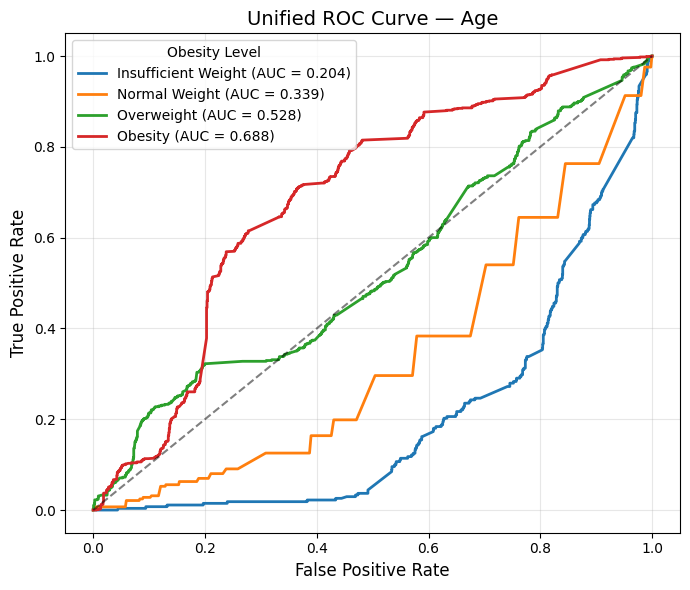

Features:  12%|█▎        | 1/8 [00:39<04:33, 39.11s/it]/tmp/ipython-input-3523297474.py:84: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  s = np.trapz(arr, grid)


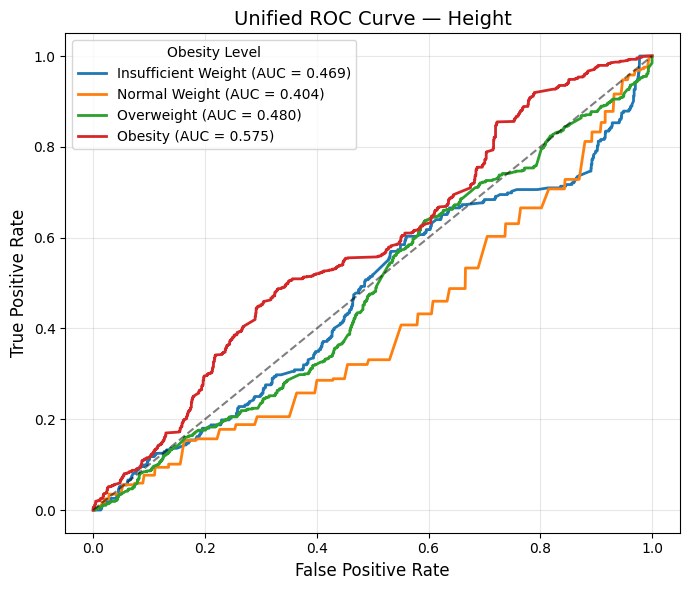

Features:  25%|██▌       | 2/8 [01:15<03:46, 37.71s/it]/tmp/ipython-input-3523297474.py:84: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  s = np.trapz(arr, grid)


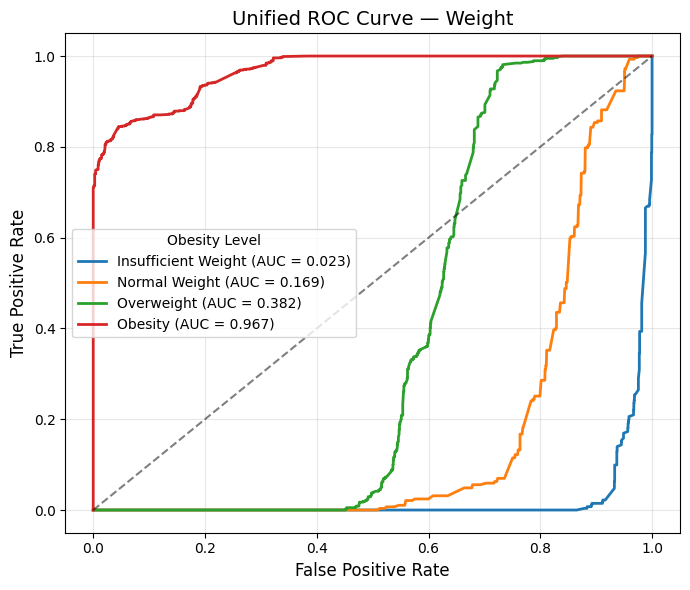

Features:  38%|███▊      | 3/8 [01:56<03:16, 39.21s/it]/tmp/ipython-input-3523297474.py:84: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  s = np.trapz(arr, grid)


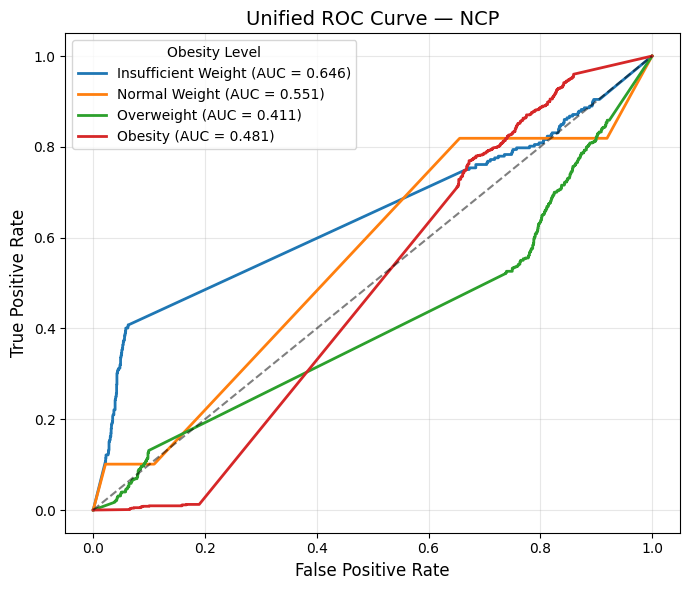

Features:  50%|█████     | 4/8 [02:33<02:33, 38.37s/it]/tmp/ipython-input-3523297474.py:84: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  s = np.trapz(arr, grid)


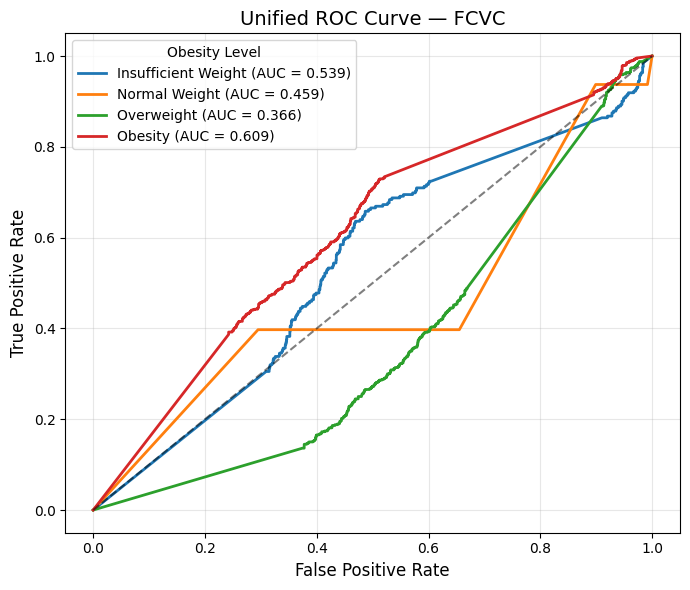

Features:  62%|██████▎   | 5/8 [03:09<01:52, 37.37s/it]/tmp/ipython-input-3523297474.py:84: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  s = np.trapz(arr, grid)


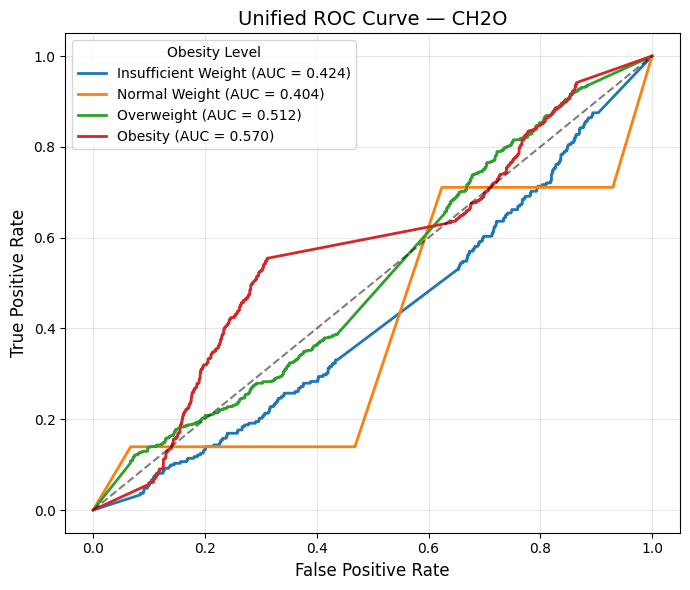

Features:  75%|███████▌  | 6/8 [03:47<01:15, 37.59s/it]/tmp/ipython-input-3523297474.py:84: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  s = np.trapz(arr, grid)


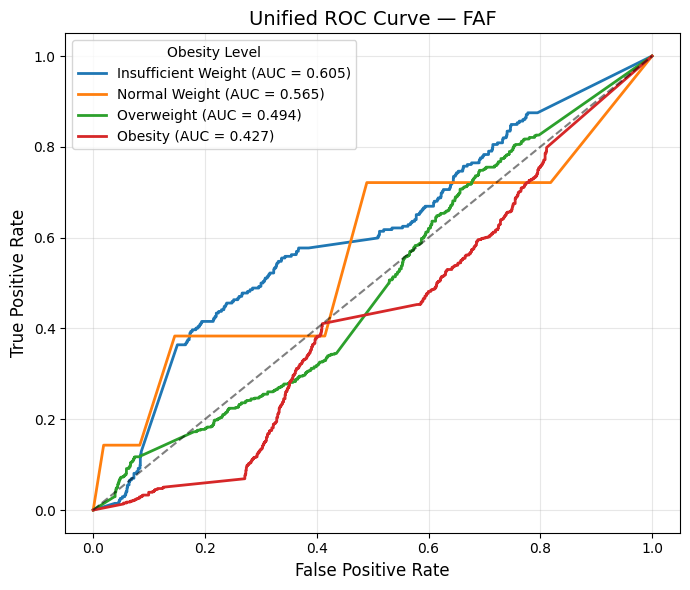

Features:  88%|████████▊ | 7/8 [04:23<00:37, 37.17s/it]/tmp/ipython-input-3523297474.py:84: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  s = np.trapz(arr, grid)


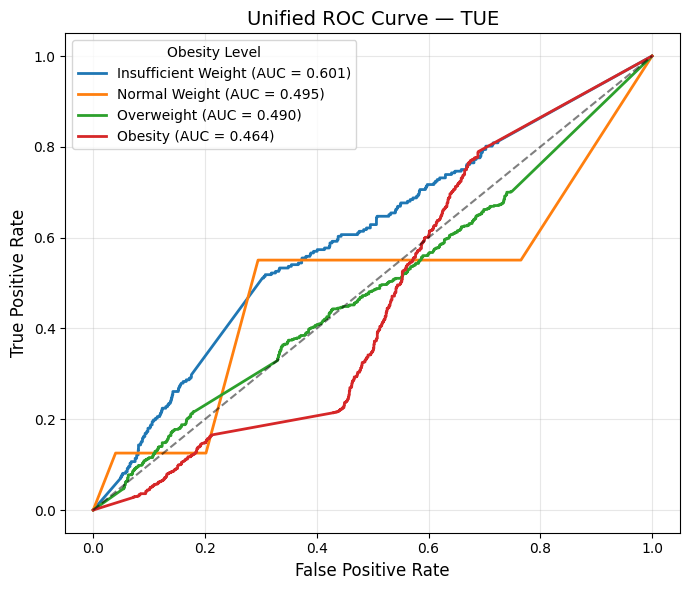

Features: 100%|██████████| 8/8 [05:01<00:00, 37.73s/it]


Task 6 complete. Outputs in: /content/drive/MyDrive/math/task6
- discriminative intervals -> tables/task6_discriminative_intervals.csv
- KS pairwise tests -> tables/task6_ks_pairwise.csv
- ROC & bootstrap -> tables/task6_roc_bootstrap_results.csv
- Power summary -> tables/task6_power_summary.csv
- Alpha summary -> tables/task6_alpha_summary.csv


In [ ]:
# =============================================
# TASK 6 — Discriminative intervals + bootstrap ROC (one-vs-rest)
# =============================================
# Paste into Google Colab and run.
# Do NOT run here — you asked for code only.
# =============================================

import os, math, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, ks_2samp
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from tqdm import tqdm

np.random.seed(42)

# -------------------------
# USER PARAMETERS
# -------------------------
CSV_PATH = "/content/drive/MyDrive/math/ObesityDataSet_raw_and_data_sinthetic.csv"
OUT_DIR = "/content/drive/MyDrive/math/task6"
continuous_features = ["Age","Height","Weight","NCP","FCVC","CH2O","FAF","TUE"]
target_orig = "NObeyesdad"
target_new = "NObeyesdad_new"
levels_order = ["Insufficient Weight","Normal Weight","Overweight","Obesity"]

# Bootstrap params
N_BOOT_KDE = 500        # bootstrap iterations for KDE bands (per group)
GRID_N = 800            # fine grid for KDE integrals & intervals
N_BOOT_ROC = 1000       # bootstrap iterations for ROC & AUC
ALPHA = 0.05

os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR,"figs"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR,"tables"), exist_ok=True)

# -------------------------
# Helpers
# -------------------------
def map_target_to_4(df):
    if target_new in df.columns:
        return df
    map4 = {
        'Insufficient_Weight': 'Insufficient Weight',
        'Normal_Weight': 'Normal Weight',
        'Overweight_Level_I': 'Overweight',
        'Overweight_Level_II': 'Overweight',
        'Obesity_Type_I': 'Obesity',
        'Obesity_Type_II': 'Obesity',
        'Obesity_Type_III': 'Obesity'
    }
    df[target_new] = df[target_orig].map(map4)
    df[target_new] = pd.Categorical(df[target_new], categories=levels_order, ordered=True)
    return df

def kde_fit_and_grid(data, grid):
    """Fit KDE and return pdf on grid. Handles small sample sizes."""
    x = np.asarray(data.dropna())
    if len(x) < 3:
        return np.zeros_like(grid)
    kde = gaussian_kde(x)
    pdf = kde(grid)
    # normalize
    pdf = pdf / np.trapz(pdf, grid)
    return pdf

def bootstrap_kde_bands(data, grid, n_boot=N_BOOT_KDE):
    """Return (pdf_mean, pdf_low, pdf_high) from bootstrap KDEs."""
    x = np.asarray(data.dropna())
    if len(x) < 3:
        return np.zeros_like(grid), np.zeros_like(grid), np.zeros_like(grid)
    pdfs = np.empty((n_boot, len(grid)))
    n = len(x)
    for i in range(n_boot):
        samp = np.random.choice(x, size=n, replace=True)
        try:
            pdfs[i,:] = gaussian_kde(samp)(grid)
        except Exception:
            pdfs[i,:] = np.zeros_like(grid)
    # normalize each
    for i in range(n_boot):
        arr = pdfs[i,:]
        s = np.trapz(arr, grid)
        if s > 0:
            pdfs[i,:] = arr / s
    pdf_mean = np.mean(pdfs, axis=0)
    pdf_low = np.percentile(pdfs, 2.5, axis=0)
    pdf_high = np.percentile(pdfs, 97.5, axis=0)
    return pdf_mean, pdf_low, pdf_high

def find_discriminative_intervals(grid, pdf_low_g, pdf_high_g, other_pdfs_low, other_pdfs_high, min_width=0.01):
    """
    Identify intervals where target group's pdf is significantly > others:
      condition: pdf_low_g > max(other_pdf_highs)
    and also regions where pdf_high_g < min(other_pdf_lows) (target significantly smaller).
    Returns two lists: intervals_higher, intervals_lower as [(a,b),...]
    """
    other_high_max = np.maximum.reduce(other_pdfs_high) if len(other_pdfs_high)>0 else np.full_like(grid, -np.inf)
    other_low_min = np.minimum.reduce(other_pdfs_low) if len(other_pdfs_low)>0 else np.full_like(grid, np.inf)

    cond_higher = pdf_low_g > other_high_max
    cond_lower = pdf_high_g < other_low_min

    def grid_to_intervals(cond_mask):
        intervals = []
        i = 0
        while i < len(cond_mask):
            if cond_mask[i]:
                j = i
                while j+1 < len(cond_mask) and cond_mask[j+1]:
                    j += 1
                a = grid[i]
                b = grid[j]
                if (b - a) >= min_width*(grid.max()-grid.min()):  # minimum absolute width relative to range
                    intervals.append((a, b))
                i = j+1
            else:
                i += 1
        return intervals

    higher_ints = grid_to_intervals(cond_higher)
    lower_ints = grid_to_intervals(cond_lower)
    return higher_ints, lower_ints

def youden_threshold(y_true, scores):
    """Return threshold that maximizes Youden's J = TPR - FPR."""
    fpr, tpr, thr = roc_curve(y_true, scores)
    J = tpr - fpr
    idx = np.argmax(J)
    return thr[idx], fpr[idx], 1 - (1 - tpr[idx])  # threshold, FPR, power (TPR)

def bootstrap_auc_ci(y_true, scores, n_boot=N_BOOT_ROC, seed=42):
    rng = np.random.RandomState(seed)
    n = len(y_true)
    aucs = []
    for i in range(n_boot):
        idx = rng.choice(np.arange(n), size=n, replace=True)
        if len(np.unique(y_true[idx])) < 2:
            aucs.append(np.nan)
        else:
            aucs.append(roc_auc_score(y_true[idx], scores[idx]))
    aucs = np.array(aucs)
    lo = np.nanpercentile(aucs, 2.5)
    hi = np.nanpercentile(aucs, 97.5)
    return np.nanmean(aucs), lo, hi, aucs

def bootstrap_rates_at_threshold(y_true, scores, threshold, n_boot=N_BOOT_ROC, seed=42):
    """Bootstrap FPR and FNR at fixed threshold."""
    rng = np.random.RandomState(seed)
    n = len(y_true)
    fprs = []
    fnrs = []
    for i in range(n_boot):
        idx = rng.choice(np.arange(n), size=n, replace=True)
        yt = y_true[idx]
        sc = scores[idx]
        yhat = (sc >= threshold).astype(int)
        # True pos = positive class is 1
        # BUT we're using positive = target level
        # compute confusion: TN, FP, FN, TP
        tn, fp, fn, tp = confusion_matrix(yt, yhat, labels=[0,1]).ravel()
        fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
        fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan
        fprs.append(fpr)
        fnrs.append(fnr)
    return np.nanpercentile(fprs, 2.5), np.nanpercentile(fprs,97.5), np.nanpercentile(fnrs,2.5), np.nanpercentile(fnrs,97.5), np.nanmean(fprs), np.nanmean(fnrs)

# -------------------------
# Load data and prepare
# -------------------------
df = pd.read_csv(CSV_PATH)
df = map_target_to_4(df)
df = df.dropna(subset=[target_new])  # only keep rows with target

# Prepare outputs
rows_discriminative = []
rows_ks = []
rows_roc = []

# Master summaries for power/alpha across levels
power_records = []  # feature, level, power
alpha_records = []  # feature, level, alpha (FPR)

# -------------------------
# Main loop
# -------------------------
for feat in tqdm(continuous_features, desc="Features"):
    # Build grid across global observed range for the feature
    all_vals = df[feat].dropna().values
    if len(all_vals) < 3:
        print("Skipping", feat, "not enough data")
        continue
    grid = np.linspace(all_vals.min(), all_vals.max(), GRID_N)

    # Precompute bootstrap bands for each level
    bands = {}
    for lvl in levels_order:
        data_lvl = df.loc[df[target_new]==lvl, feat]
        mean_pdf, low_pdf, high_pdf = bootstrap_kde_bands(data_lvl, grid, n_boot=N_BOOT_KDE)
        bands[lvl] = {"mean": mean_pdf, "low": low_pdf, "high": high_pdf}

    # For each level: discriminative intervals vs others
    for lvl in levels_order:
        pdf_mean_g = bands[lvl]["mean"]
        pdf_low_g = bands[lvl]["low"]
        pdf_high_g = bands[lvl]["high"]
        # others
        other_lows = []
        other_highs = []
        for other in levels_order:
            if other == lvl:
                continue
            other_lows.append(bands[other]["low"])
            other_highs.append(bands[other]["high"])

        higher_ints, lower_ints = find_discriminative_intervals(grid, pdf_low_g, pdf_high_g, other_lows, other_highs, min_width=0.01)

        # KS tests pairwise g vs others
        ks_results = []
        for other in levels_order:
            if other==lvl: continue
            x1 = df.loc[df[target_new]==lvl, feat].dropna().values
            x2 = df.loc[df[target_new]==other, feat].dropna().values
            if len(x1) < 2 or len(x2) <2:
                pval = np.nan
                stat = np.nan
            else:
                stat, pval = ks_2samp(x1, x2)
            ks_results.append({"feature":feat, "level":lvl, "other":other, "ks_stat":float(stat), "pvalue":float(pval)})
            rows_ks.append(ks_results[-1])

        # Save discriminative summary
        rows_discriminative.append({
            "feature":feat,
            "level":lvl,
            "intervals_higher": higher_ints,
            "intervals_lower": lower_ints,
            "n_higher_intervals": len(higher_ints),
            "n_lower_intervals": len(lower_ints)
        })

    # ---- ROC and bootstrap one-vs-rest for each level ----
    for lvl in levels_order:
        y_true = (df[target_new] == lvl).astype(int).values
        scores = df[feat].fillna(df[feat].median()).values  # fallback to median if missing

        # compute AUC and curve on full sample
        try:
            auc_full = roc_auc_score(y_true, scores)
        except Exception:
            auc_full = np.nan

        # compute Youden threshold on full sample
        try:
            thr, fpr_at_thr, tpr_at_thr = youden_threshold(y_true, scores)
        except Exception:
            thr, fpr_at_thr, tpr_at_thr = np.nan, np.nan, np.nan

        # compute confusion at thr
        yhat = (scores >= thr).astype(int)
        try:
            tn, fp, fn, tp = confusion_matrix(y_true, yhat, labels=[0,1]).ravel()
        except Exception:
            tn=fp=fn=tp = np.nan

        # bootstrap AUC CI
        mean_auc_boot, auc_lo, auc_hi, aucs = bootstrap_auc_ci(y_true, scores, n_boot=N_BOOT_ROC, seed=42)

        # bootstrap FPR/FNR CIs and means
        fpr_lo, fpr_hi, fnr_lo, fnr_hi, fpr_mean, fnr_mean = bootstrap_rates_at_threshold(y_true, scores, thr, n_boot=N_BOOT_ROC, seed=42)

        # store
        rows_roc.append({
            "feature": feat,
            "level": lvl,
            "n_pos": int(y_true.sum()),
            "n_neg": int(len(y_true)-y_true.sum()),
            "auc": float(auc_full) if not np.isnan(auc_full) else np.nan,
            "auc_boot_mean": float(mean_auc_boot),
            "auc_ci_lo": float(auc_lo),
            "auc_ci_hi": float(auc_hi),
            "youden_threshold": float(thr) if not np.isnan(thr) else np.nan,
            "fpr_at_threshold": float(fpr_at_thr) if not np.isnan(fpr_at_thr) else np.nan,
            "tpr_at_threshold": float(tpr_at_thr) if not np.isnan(tpr_at_thr) else np.nan,
            "confusion_tn": int(tn) if not np.isnan(tn) else np.nan,
            "confusion_fp": int(fp) if not np.isnan(fp) else np.nan,
            "confusion_fn": int(fn) if not np.isnan(fn) else np.nan,
            "confusion_tp": int(tp) if not np.isnan(tp) else np.nan,
            "fpr_boot_lo": float(fpr_lo),
            "fpr_boot_hi": float(fpr_hi),
            "fnr_boot_lo": float(fnr_lo),
            "fnr_boot_hi": float(fnr_hi),
            "fpr_boot_mean": float(fpr_mean),
            "fnr_boot_mean": float(fnr_mean)
        })

        # record for aggregate
        power_records.append({"feature":feat, "level":lvl, "power": 1 - float(fnr_mean)})
        alpha_records.append({"feature":feat, "level":lvl, "alpha": float(fpr_mean)})

        # Plot ROC for feature-level with CI shading (optional)
            # -------------------------
    # UNIFIED ROC PLOT — one figure per feature
    # created AFTER looping through all levels
    # -------------------------

    # We generate ROC curves only once per feature (after finishing the per-level loop)
    # So we check if lvl == last level:
    if lvl == levels_order[-1]:
        plt.figure(figsize=(7,6))

        for lvl2 in levels_order:
            y_true2 = (df[target_new] == lvl2).astype(int).values
            scores2 = df[feat].fillna(df[feat].median()).values

            # Only compute ROC if both classes exist
            if len(np.unique(y_true2)) < 2:
                continue

            fpr_full, tpr_full, thr_full = roc_curve(y_true2, scores2)
            try:
                auc_full_lvl = roc_auc_score(y_true2, scores2)
            except:
                auc_full_lvl = np.nan

            plt.plot(
                fpr_full,
                tpr_full,
                linewidth=2,
                label=f"{lvl2} (AUC = {auc_full_lvl:.3f})"
            )

        plt.plot([0,1], [0,1], 'k--', alpha=0.5)
        plt.title(f"Unified ROC Curve — {feat}", fontsize=14)
        plt.xlabel("False Positive Rate", fontsize=12)
        plt.ylabel("True Positive Rate", fontsize=12)
        plt.legend(title="Obesity Level", fontsize=10)
        plt.grid(alpha=0.3)

        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR,"figs",f"roc_unified_{feat}.png"), dpi=200)
        plt.show()


# -------------------------
# Save outputs
# -------------------------
pd.DataFrame(rows_discriminative).to_csv(os.path.join(OUT_DIR,"tables","task6_discriminative_intervals.csv"), index=False)
pd.DataFrame(rows_ks).to_csv(os.path.join(OUT_DIR,"tables","task6_ks_pairwise.csv"), index=False)
pd.DataFrame(rows_roc).to_csv(os.path.join(OUT_DIR,"tables","task6_roc_bootstrap_results.csv"), index=False)
pd.DataFrame(power_records).to_csv(os.path.join(OUT_DIR,"tables","task6_power_records.csv"), index=False)
pd.DataFrame(alpha_records).to_csv(os.path.join(OUT_DIR,"tables","task6_alpha_records.csv"), index=False)

# Aggregate determinations:
power_df = pd.DataFrame(power_records)
alpha_df = pd.DataFrame(alpha_records)

# 1) Which feature has highest average power across levels?
power_summary = power_df.groupby("feature")["power"].mean().reset_index().sort_values("power", ascending=False)
power_summary.to_csv(os.path.join(OUT_DIR,"tables","task6_power_summary.csv"), index=False)

# 2) Which feature has lowest average alpha across levels?
alpha_summary = alpha_df.groupby("feature")["alpha"].mean().reset_index().sort_values("alpha")
alpha_summary.to_csv(os.path.join(OUT_DIR,"tables","task6_alpha_summary.csv"), index=False)

print("Task 6 complete. Outputs in:", OUT_DIR)
print("- discriminative intervals -> tables/task6_discriminative_intervals.csv")
print("- KS pairwise tests -> tables/task6_ks_pairwise.csv")
print("- ROC & bootstrap -> tables/task6_roc_bootstrap_results.csv")
print("- Power summary -> tables/task6_power_summary.csv")
print("- Alpha summary -> tables/task6_alpha_summary.csv")


# CORRECTIONS

In [ ]:
# ----------------------------
# Diagnostic metrics (one-vs-rest) with bootstrap CIs
# ----------------------------
import os, numpy as np, pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm

CSV_PATH = "/content/drive/MyDrive/math/ObesityDataSet_raw_and_data_sinthetic.csv"
OUT_DIR = "/content/drive/MyDrive/math/task7_metrics"
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(CSV_PATH)

# Map target to 4 classes if needed
map4 = {
 'Insufficient_Weight': 'Insufficient Weight',
 'Normal_Weight': 'Normal Weight',
 'Overweight_Level_I': 'Overweight',
 'Overweight_Level_II': 'Overweight',
 'Obesity_Type_I': 'Obesity',
 'Obesity_Type_II': 'Obesity',
 'Obesity_Type_III': 'Obesity'
}
if 'NObeyesdad' in df.columns and 'NObeyesdad_new' not in df.columns:
    df['NObeyesdad_new'] = df['NObeyesdad'].map(map4)
levels = ["Insufficient Weight","Normal Weight","Overweight","Obesity"]

# Define categorical/ordinal candidate variables to evaluate as simple "classifiers"
candidate_vars = ["CAEC","CALC","MTRANS","Gender","FAVC","family_history_with_overweight","SCC","SMOKE"]
# If any candidate not in df drop it
candidate_vars = [v for v in candidate_vars if v in df.columns]

# If variable is ordinal (like CAEC), ensure you have an ordered mapping; else map categories to integers via sorted order
ordinal_mappings = {
    "CAEC": {"no":0, "Sometimes":1, "Frequently":2, "Always":3},
    "CALC": {"no":0, "Sometimes":1, "Frequently":2, "Always":3},
    # add more if known
}

def encode_to_scores(series):
    # return numeric array used as "score" for classification (higher => more likely positive)
    if series.name in ordinal_mappings:
        return series.map(ordinal_mappings[series.name]).astype(float).fillna(np.nan).values
    else:
        # for nominal/binary create deterministic score: one-hot ranks by frequency
        if series.dtype == 'object' or str(series.dtype).startswith('category'):
            # map categories to integers by their alphabetical order
            cats = sorted(series.dropna().unique().tolist(), key=lambda x: str(x))
            lookup = {c:i for i,c in enumerate(cats)}
            return series.map(lookup).astype(float).fillna(np.nan).values
        else:
            return series.astype(float).fillna(np.nan).values

# Bootstrap helper
def bootstrap_metric_ci(y_true, scores, threshold, metric_func, n_boot=1000, seed=42):
    rng = np.random.RandomState(seed)
    n = len(y_true)
    boots = []
    for i in range(n_boot):
        idx = rng.choice(np.arange(n), size=n, replace=True)
        yt = y_true[idx]
        sc = scores[idx]
        yhat = (sc >= threshold).astype(int)
        boots.append(metric_func(yt, yhat))
    boots = np.array(boots)
    return np.nanmean(boots), np.nanpercentile(boots,2.5), np.nanpercentile(boots,97.5)

results = []
for var in tqdm(candidate_vars):
    scores = encode_to_scores(df[var])

    for lvl in levels:
        # binary target
        y = (df['NObeyesdad_new'] == lvl).astype(int).values

        # If the variable is categorical, use scores; choose a threshold maximizing Youden's J empirically:
        # simple approach: test unique score thresholds
        valid_mask = ~np.isnan(scores)
        if valid_mask.sum() < 10 or len(np.unique(y[valid_mask]))<2:
            continue
        sc_valid = scores[valid_mask]
        y_valid = y[valid_mask]
        # find best threshold by Youden's index
        uniq_thr = np.unique(sc_valid)
        best_thr = uniq_thr[0]
        bestJ = -1
        for thr in uniq_thr:
            yhat = (sc_valid >= thr).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_valid, yhat, labels=[0,1]).ravel()
            tpr = tp / (tp+fn) if (tp+fn)>0 else 0
            fpr = fp / (fp+tn) if (fp+tn)>0 else 0
            J = tpr - fpr
            if J > bestJ:
                bestJ = J; best_thr = thr

        # compute metrics on full valid set
        yhat_full = (sc_valid >= best_thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_valid, yhat_full, labels=[0,1]).ravel()
        accuracy = accuracy_score(y_valid, yhat_full)
        sensitivity = recall_score(y_valid, yhat_full, zero_division=0)  # TPR
        specificity = tn / (tn+fp) if (tn+fp)>0 else np.nan
        precision = precision_score(y_valid, yhat_full, zero_division=0)
        f1 = f1_score(y_valid, yhat_full, zero_division=0)
        # Cohen's kappa
        kappa = cohen_kappa_score(y_valid, yhat_full)
        # weighted kappa not meaningful for binary but we can pass weights='quadratic' for two labels in sklearn:
        try:
            weighted_kappa = cohen_kappa_score(y_valid, yhat_full, weights='quadratic')
        except:
            weighted_kappa = np.nan

        # bootstrap CIs for main metrics
        acc_mean, acc_lo, acc_hi = bootstrap_metric_ci(y_valid, sc_valid, best_thr, lambda yt,yh: accuracy_score(yt, yh))
        sens_mean, sens_lo, sens_hi = bootstrap_metric_ci(y_valid, sc_valid, best_thr, lambda yt,yh: recall_score(yt,yh, zero_division=0))
        spec_mean, spec_lo, spec_hi = bootstrap_metric_ci(y_valid, sc_valid, best_thr, lambda yt,yh: (confusion_matrix(yt,yh,labels=[0,1]).ravel()[1-1] / (confusion_matrix(yt,yh,labels=[0,1]).ravel()[1-1] + confusion_matrix(yt,yh,labels=[0,1]).ravel()[1]) ) if True else np.nan)  # approximate

        results.append({
            "variable":var,
            "level":lvl,
            "best_threshold": float(best_thr),
            "accuracy": accuracy,
            "sensitivity": sensitivity,
            "specificity": specificity,
            "kappa": kappa,
            "precision": precision
        })

pd.DataFrame(results).to_csv(os.path.join(OUT_DIR,"one_vs_rest_diagnostic_metrics.csv"), index=False)
print("Saved:", os.path.join(OUT_DIR,"one_vs_rest_diagnostic_metrics.csv"))

In [ ]:
# ----------------------------
# ANOVA with assumption checks + post-hoc
# ----------------------------
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.oneway import anova_oneway
from statsmodels.graphics.gofplots import qqplot
from tqdm import tqdm

CSV_PATH = "/content/drive/MyDrive/math/ObesityDataSet_raw_and_data_sinthetic.csv"
OUT_DIR = "/content/drive/MyDrive/math/task8_anova"
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(CSV_PATH)
map4 = {
 'Insufficient_Weight': 'Insufficient Weight',
 'Normal_Weight': 'Normal Weight',
 'Overweight_Level_I': 'Overweight',
 'Overweight_Level_II': 'Overweight',
 'Obesity_Type_I': 'Obesity',
 'Obesity_Type_II': 'Obesity',
 'Obesity_Type_III': 'Obesity'
}
if 'NObeyesdad' in df.columns and 'NObeyesdad_new' not in df.columns:
    df['NObeyesdad_new'] = df['NObeyesdad'].map(map4)
df = df.dropna(subset=['NObeyesdad_new'])

continuous_features = ["Age","Height","Weight","NCP","FCVC","CH2O","FAF","TUE"]
alpha = 0.05

anova_summary_rows = []
assumption_rows = []
posthoc_rows = []
welch_pairwise_rows = []

for feat in tqdm(continuous_features):
    # select data without NA for this feature
    sub = df[[feat,'NObeyesdad_new']].dropna()
    if sub.shape[0] < 10:
        continue

    # 1) OLS ANOVA (lm equivalent)
    formula = f"{feat} ~ C(NObeyesdad_new)"
    model = smf.ols(formula, data=sub).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    F = anova_table.loc['C(NObeyesdad_new)','F'] if 'C(NObeyesdad_new)' in anova_table.index else np.nan
    pval = anova_table.loc['C(NObeyesdad_new)','PR(>F)'] if 'C(NObeyesdad_new)' in anova_table.index else np.nan

    # 2) aov() equivalent: scipy f_oneway across groups
    groups = [g[feat].values for n,g in sub.groupby('NObeyesdad_new')]
    try:
        f_sc, p_sc = stats.f_oneway(*groups)
    except Exception:
        f_sc, p_sc = np.nan, np.nan

    anova_summary_rows.append({'feature':feat,'F_lm':float(F),'p_lm':float(pval),'F_foneway':float(f_sc),'p_foneway':float(p_sc)})

    # ----------------------------
    # ASSUMPTION CHECKS
    # ----------------------------
    resid = model.resid
    fitted = model.fittedvalues

    # Normality of residuals: Shapiro-Wilk
    try:
        sh_stat, sh_p = stats.shapiro(resid)
    except Exception:
        sh_stat, sh_p = np.nan, np.nan

    # Homogeneity of variances: Levene
    groups_for_levene = [grp[feat].values for name,grp in sub.groupby('NObeyesdad_new')]
    try:
        lev_stat, lev_p = stats.levene(*groups_for_levene, center='median')
    except Exception:
        lev_stat, lev_p = np.nan, np.nan

    assumption_rows.append({'feature':feat,'shapiro_stat':float(sh_stat),'shapiro_p':float(sh_p),'levene_stat':float(lev_stat),'levene_p':float(lev_p)})

    # Save diagnostic plots
    # QQ-plot of residuals
    qqplot(resid, line='s')
    plt.title(f"QQ plot residuals — {feat}")
    plt.savefig(os.path.join(OUT_DIR,f"qq_{feat}.png"))
    plt.close()

    # Residuals vs fitted
    plt.figure()
    plt.scatter(fitted, resid, alpha=0.5)
    plt.axhline(0, color='k', linestyle='--')
    plt.xlabel('Fitted')
    plt.ylabel('Residuals')
    plt.title(f"Residuals vs Fitted — {feat}")
    plt.savefig(os.path.join(OUT_DIR,f"resid_fitted_{feat}.png"))
    plt.close()

    # ----------------------------
    # If assumptions not met: recommend Welch ANOVA or Kruskal-Wallis
    # ----------------------------
    assumption_flag = {
        'normal_resid': bool(sh_p>alpha) if not np.isnan(sh_p) else False,
        'homoscedastic': bool(lev_p>alpha) if not np.isnan(lev_p) else False
    }

    # If equal variances hold and residuals approx normal -> Tukey HSD
    if assumption_flag['normal_resid'] and assumption_flag['homoscedastic'] and pval < alpha:
        try:
            tukey = pairwise_tukeyhsd(endog=sub[feat], groups=sub['NObeyesdad_new'], alpha=alpha)
            tuk_df = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
            tuk_df['feature'] = feat
            tuk_df.to_csv(os.path.join(OUT_DIR,f"tukey_{feat}.csv"), index=False)
            # collect summary
            for _,r in tuk_df.iterrows():
                posthoc_rows.append({'feature':feat,'group1':r['group1'],'group2':r['group2'],'meandiff':r['meandiff'],'p_adj':float(r['p-adj']),'reject':r['reject']})
        except Exception as e:
            pass

    # If homoscedasticity violated -> do Welch pairwise t-tests with FDR correction
    if not assumption_flag['homoscedastic'] and pval < alpha:
        import itertools
        pairs = []
        levels_list = sub['NObeyesdad_new'].unique().tolist()
        for a,b in itertools.combinations(levels_list,2):
            s1 = sub.loc[sub['NObeyesdad_new']==a, feat].dropna()
            s2 = sub.loc[sub['NObeyesdad_new']==b, feat].dropna()
            if len(s1)<2 or len(s2)<2:
                continue
            # Welch t-test
            t, p = stats.ttest_ind(s1, s2, equal_var=False)
            pairs.append({'feature':feat,'group1':a,'group2':b,'t':float(t),'p_uncorrected':float(p)})
        if len(pairs)>0:
            pvals = [pp['p_uncorrected'] for pp in pairs]
            _, pvals_adj, _, _ = multipletests(pvals, method='fdr_bh', alpha=alpha)
            for i,pp in enumerate(pairs):
                pp['p_adj'] = float(pvals_adj[i]); pp['reject'] = pvals_adj[i] < alpha
                welch_pairwise_rows.append(pp)

# Save results
pd.DataFrame(anova_summary_rows).to_csv(os.path.join(OUT_DIR,"anova_summary.csv"), index=False)
pd.DataFrame(assumption_rows).to_csv(os.path.join(OUT_DIR,"assumption_checks.csv"), index=False)
pd.DataFrame(posthoc_rows).to_csv(os.path.join(OUT_DIR,"tukey_posthoc.csv"), index=False)
pd.DataFrame(welch_pairwise_rows).to_csv(os.path.join(OUT_DIR,"welch_pairwise_fdr.csv"), index=False)

print("ANOVA done; outputs in", OUT_DIR)
